# B03 Revealing the Dependency of Default Network Perturbation on Pain Experience and the Influence of Coping
## Code for the Analysis

This Jupyter Notebook is the basis of the Manuscript by *Nils Jannik Heukamp et al.*. All code is written by *Nils Jannik Heukamp*. 

If you refer to the analysis or code conducted here, please cite the paper appropriately.

DOI will be added after publication in an updated notebook.

Let's start. First we import the necessary libraries. Please refer to the packages documentation for further information

In [1]:
# basic libraries
import pickle
import os
import numpy as np
import pandas as pd

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors, patches
from matplotlib.patches import Rectangle
from statannotations.Annotator import Annotator

# Network Libraries
import networkx as nx

# cluster batching
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

# fMRI interface
from nilearn.datasets import fetch_atlas_difumo
from nilearn.maskers import NiftiMapsMasker
import nilearn.plotting as nplot
from nilearn.connectome import ConnectivityMeasure
from nilearn.connectome import sym_matrix_to_vec, vec_to_sym_matrix

# caching
from joblib import Memory

# stats
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from statsmodels.stats.multitest import multipletests
import semopy as sem
from pingouin import ttest

# Ipypthon display
from IPython.display import Markdown, display


now just some small stuff.
1. a short helper function to make printed dataframes look nicer. 
2. a function to convert a list to a dict
3. a function to minmax a matrix
4. set the numpy random seed for reproducibility

In [2]:
# short helper function to print markdown tables from pandas dataframes
def printmd(string):
    display(Markdown(string))

# function to convert a list to a dictionary


def Convert(lst):
    res_dct = {i: lst[i] for i in range(0, len(lst))}
    return res_dct

# helper function to min max normalize a matrix


def minmax_matrix(matrix):
    return (matrix - np.nanmin(matrix))/(np.nanmax(matrix) - np.nanmin(matrix))


# set the random seed for reproducibility
np.random.seed(230923)


Now I'am going to initialize a Cluster Clien using dask. This notebook was written to work on a Cluster, more specifically the nesh cluster of Kiel University (https://www.rz.uni-kiel.de/de/angebote/hiperf/nesh). IN the end it's just a python job client, but things are going really fast. 
Nevertheless everythin here could also be done on a normal PC, but it would take days to weeks.

In [3]:
# Initialize Cluster
cluster = SLURMCluster(
    n_workers=0,  # 300 is more or less max what the cluster allows per user
    cores=1,
    processes=1,
    memory="10GB",   # Must be scaled up to 64 if individual connectomes not precomputed
    shebang='#!/usr/bin/env bash',
    queue="cluster",
    walltime="24:00:00",
    local_directory='/tmp',
    death_timeout="4000s",   # must be this high otherwise looses workers
    interface="ib0",
    log_directory=f'{os.environ["HOME"]}/dask_jobqueue_logs/')

# Scale up and down depending on the number of jobs
cluster.adapt(minimum_jobs=0, maximum_jobs=200)

# Initialize client
client = Client(cluster)


/gxfs_home/cau/suknp018/miniconda3/envs/B03_virtenv/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38977 instead
  warnings.warn(


Now I make some objects pointing to directories. Makes things less messy in the code. Furthermore I create a cache. This is important because otherwise we would need to recomute everything every time or make a lot of ugly if sentences with pickle dump.

In [4]:
user_base = os.environ['WORK']
data_dir = os.path.join(user_base, "B03")
derivatives_dir = os.path.join(data_dir, 'derivatives')
phenotype_dir = os.path.join(data_dir, 'phenotype')
nilearn_dir = os.path.join(derivatives_dir, 'nilearn')
atlas_dir = os.path.join(derivatives_dir, 'nilearn/atlas/')
connect_dir = os.path.join(derivatives_dir, 'nilearn/connectome/')
network_dir = os.path.join(derivatives_dir, 'nilearn/network/')
denoise_dir = os.path.join(derivatives_dir, 'nilearn/denoised/')
timeseries_dir = os.path.join(derivatives_dir, 'nilearn/timeseries/')
figures_dir = os.path.join(derivatives_dir, 'figures')
results_dir = os.path.join(derivatives_dir, 'results')

cache_dir = os.path.join(network_dir, 'joblib_cache_network')
memory = Memory(cache_dir, verbose=0)

for dir in [nilearn_dir, connect_dir, network_dir, figures_dir, results_dir]:
    os.makedirs(dir, exist_ok=True)


Now let's read the data. I prepared it in advance to not have too much code here, that is unnecessaey for the main analysis. There is the feature_df with all psychological and pain experience features and the denoise_df with the paths to thé denoise images. 

In [5]:
feature_df = pd.read_pickle(os.path.join(phenotype_dir, 'features.pklz'))

denoise_df = pd.read_pickle(os.path.join(
    denoise_dir, 'denoised_images_ses-01.pklz'))


In [6]:
# there has been some missindexing at the beginning of the study. Just shortly correcting this.
old_index = list(denoise_df.index)

reindexer = {
    'sub-202': 'sub-581',
    'sub-203': 'sub-582',
    'sub-213': 'sub-583',
    'sub-226': 'sub-584',
    'sub-234': 'sub-585',
    'sub-238': 'sub-586',
    'sub-240': 'sub-587',
    'sub-245': 'sub-588',
    'sub-247': 'sub-589',
}
new_index = old_index

for i in range(len(old_index)):
    if old_index[i] in reindexer.keys():
        new_index[i] = reindexer[new_index[i]]

denoise_df = denoise_df.set_axis(new_index)

# improve the naming of the groups
denoise_df.group = denoise_df.group.replace({'0': 'HP',
                                             '2': 'CBP',
                                             '5': 'SBP'})


Now let's look if all the data is here. There are thes few subjects for whom no resting-state was made, but because of stuff they are in the feature_df. 
Still they're not in the paper as resting-state imaging was an inclusion criteria for the analysis. So please ignore this.

In [7]:
# get the indices of the subjects that are in feature_df but not in denoise_df
missing_subjects = feature_df.index.difference(denoise_df.index)
print(missing_subjects)
feature_df_original = feature_df.copy()

# drop the subjects that are not in denoise_df or not in feature_df
feature_df = feature_df.drop(missing_subjects)
denoise_df = denoise_df.loc[feature_df.index]


Index(['sub-028', 'sub-207', 'sub-211', 'sub-222', 'sub-543', 'sub-554',
       'sub-572'],
      dtype='object')


Let's have a look at the number of subjects per group and in total

In [8]:
printmd(feature_df.Subgroup.value_counts().to_frame().to_markdown())
print('In total there are', feature_df.shape[0], 'subjects')


|     |   Subgroup |
|:----|-----------:|
| SBP |         77 |
| HP  |         39 |
| CBP |         31 |

In total there are 147 subjects


Our Preparations are done. Let's dive into the analysis

***
## Feature Extraction

Here we extract the timeseries for each subject after getting the labels and some more attributes for the atlas

In [9]:
# get the important attributes
difumo_atlas = fetch_atlas_difumo(512)
difumo_atlas_maps = difumo_atlas.maps
difumo_atlas_number = [label[0] for label in difumo_atlas.labels]
difumo_atlas_networks = [label[2] for label in difumo_atlas.labels]

# store them in a nice dictionary
atlas = {}
atlas['maps'] = difumo_atlas_maps
atlas['networks'] = difumo_atlas_networks

# if the file difumo_512.npy does not exist find the coordinates
if not os.path.isfile(os.path.join(atlas_dir, 'difumo_512.npy')):
    coords = nplot.find_probabilistic_atlas_cut_coords(difumo_atlas_maps)
    np.save(os.path.join(atlas_dir, 'difumo_512.npy'), coords)
else:
    coords = np.load(os.path.join(atlas_dir, 'difumo_512.npy'))
atlas['coords'] = coords


/gxfs_home/cau/suknp018/miniconda3/envs/B03_virtenv/lib/python3.11/site-packages/nilearn/datasets/atlas.py:131: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


Next is a small wrapper function for **timeseries extraction**. Saves and reloads data and makes it easier to deploy with the cluster client

In [10]:
# function to extract timeseries from nifit resting state images
# we use the DifuMo atlas in the 512 node version


@memory.cache
def extract_timeseries(image_file, atlas_map, redo=False):

    # make a cache directory at the node of the cluster
    cache = os.path.join(os.environ['TMPDIR'], 'nilearn_cache')
    os.makedirs(cache, exist_ok=True)

    # get the number of nodes in the atlas
    atlas_len = len(atlas['labels'])
    # make a string to identify the atlas
    atlas_attribute_str = rf'DiFuMo{atlas_len}'

    # make a filename for the timeseries that refers to the atlas
    timeseries_file = image_file.split('/')[-1]
    timeseries_file = timeseries_file.replace(
        '.nii', fr'{atlas_attribute_str}_timeseries.pklz')
    timeseries_dir = '/'.join(image_file.split('/')
                              [:-1]).replace('denoised', 'timeseries')
    timeseries_file = os.path.join(timeseries_dir, timeseries_file)
    os.makedirs(timeseries_dir, exist_ok=True)

    # if the timeseries file does not exist, or if we want to redo it, extract the timeseries
    if not os.path.isfile(timeseries_file) or redo:
        masker = NiftiMapsMasker(maps_img=atlas_map,
                                 verbose=100,
                                 standardize=True,
                                 memory=cache,
                                 memory_level=50,
                                 smoothing_fwhm=5
                                 )
        timeseries = masker.fit_transform(image_file)

        # save the timeseries
        with open(timeseries_file, 'wb') as f:
            pickle.dump(timeseries, f)

    return timeseries_file


Next let's submit the jobs. Looks more complicated as it is. If already computed it reloads. If it is redoing it, it checks if it works and in case not it resubmits the job.

In [11]:
# make a nice filename for the timeseries_df
redo = False

timeseries_df_file = os.path.join(timeseries_dir, 'timeseries_df.pklz')

if not os.path.isfile(timeseries_df_file) or redo:
    # submit the jobs to the cluster
    timeseries_jobs = []
    for sub, image_file in zip(denoise_df.index, denoise_df.ica_aroma_wm_csf_global_signal_high_pass):
        job = client.submit(extract_timeseries, image_file,
                            difumo_atlas_maps,
                            )
        timeseries_jobs.append(job)
    # check jobs and get the results and put them into a list.
    # if the result takes too long ( >3 seconds) recompute locally (not enough space on the cluster. As it is most probably already computed in an earlier run we can load it via the cache function)

    timeseries_files = []
    for job in timeseries_jobs:
        try:
            timeseries_file = job.result(timeout=3)
            timeseries_files.append(timeseries_file)
        except TimeoutError:
            timeseries_file = job.result()
            print(f'did it myself {timeseries_file}')
            timeseries_files.append(timeseries_file)
    # function to load from pickle

    def load_from_pickle(file):
        obj = pickle.load(open(file, 'rb'))
        return obj
    jobs = client.map(load_from_pickle, timeseries_files)
    # load the whole pickle files from the Dataframe
    timeseries_df = pd.DataFrame(
        {'timeseries': [jobs[i].result() for i in range(len(jobs))]})
    timeseries_df.to_pickle(timeseries_df_file)
else:
    timeseries_df = pd.read_pickle(timeseries_df_file)


Discard the first five images. (See paper)

In [12]:
# throw away the first 5 images of the timeseries
timeseries_df = timeseries_df.applymap(lambda x: x[5:, :])


Compute the connectomes

In [13]:
# convert the timeseries from the dataframe into a numpy array
timeseries_array = np.array([ts for ts in timeseries_df.timeseries.to_numpy()])

# delete the timeseries files from the cluster
del timeseries_df  # clear some memory for other HPC users ;)

# calculate the connectomes using the Pearson correlation
connectomer = ConnectivityMeasure(kind='correlation')
connectomes_pearson = connectomer.fit_transform(timeseries_array)

# delete the timeseries array from the cluster
del timeseries_array

# fill the diagonal with zeros
for j in range(connectomes_pearson.shape[1]):
    connectomes_pearson[:, j, j] = 0


Now let's make subconnectomes for the networks. 

In [14]:
# we need indices for the networks

# get the unique networks
networks_unique = np.unique(atlas['networks'])

# make a list of boolean indices and a list of number indices for each network
networks_bool_idx = []
networks_num_idx = []
for network in networks_unique:
    bool_idx = np.array(atlas['networks']) == network
    networks_bool_idx.append(bool_idx)
    num_idx = np.where(np.array(atlas['networks']) == network)
    networks_num_idx.append(num_idx)
networks_bool_idx = np.array(networks_bool_idx)


In [15]:
# prepare a dictionary to store the dataframes for each network
network_dfs = {}
for network in networks_unique:
    network_dfs[network] = pd.DataFrame()


**Function for making binarized connectome-matrices**

This function takes a pearson-correlation matrix and binarizes it, by only using the top 10% of connections. 
This can lead to problems with the graph-theoretical measures as the graphs quite probably are not fully connected.
Therefore this function adds the edges of the minimum spanning tree to the top 10% of connections. 
Thereby we get a binarized connectome, that represents the strongest connections and at the same time makes sure that every node is connectes, while keeping the number of below-threshold edges as low as possible.

In [16]:
@memory.cache
def make_thresh_min_matrix(connectome):

    # Convert the input connectome to a weighted networkx graph
    G_weighted = nx.from_numpy_array(minmax_matrix(connectome))

    # Compute the minimum spanning tree of the weighted graph
    G_min = nx.minimum_spanning_tree(G_weighted)

    # Convert the minimum spanning tree to a binary matrix where any non-zero weights are converted to True
    connectome_min = nx.to_numpy_array(G_min) > 0

    # Compute the 90th percentile of weights in the input connectome
    threshold = np.nanquantile(connectome, .9)

    # Create a binary matrix where any weights above the 90th percentile are set to 1
    connectome_10 = connectome > threshold

    # Combine the binary matrices by taking their element-wise sum, then threshold the result to create a binary matrix
    connectome_min_10 = (connectome_min + connectome_10) > 0

    # Return the resulting binary matrix
    return connectome_min_10


**Function for making networkwise binarized connectome-matrices**

This function takes a whole-brain pearson-correlation matrix and binarizes it for whole-brain and every subnetwork using the method described above.
For the network-matrices it furthermore adds edges that are above the threshold for whole-brain if they are below threshold for the subnetwork.

In [17]:
@memory.cache
def make_thresh_min_networkwise_matrices(matrix, network_index=atlas['networks']):

    # Initialize a dictionary to hold the resulting matrices
    matrices = {}

    # Create a whole brain matrix by thresholding the input matrix using the make_thresh_min_matrix function
    matrices['WB'] = make_thresh_min_matrix(matrix)

    # Create network-wise matrices by iterating over each unique network in the network index
    for network in np.unique(network_index):

        # Get the indices of the nodes in the current network
        network_idx = np.array(network_index) == network

        # Extract the minimum spanning tree matrix for the current network
        G_network = nx.from_numpy_array(
            minmax_matrix(matrix[network_idx][:, network_idx]))
        network_matrix = nx.to_numpy_array(
            nx.minimum_spanning_tree(G_network)) > 0

        # Combine the network minimum spanning tre matrix with the thresholded (.9) WB matrix
        network_matrix = (
            network_matrix + (matrix[network_idx][:, network_idx] > np.nanquantile(matrix, .9))) > 0

        # Store the resulting network-wise matrix in the dictionary
        matrices[network] = network_matrix

    # Return the resulting dictionary of matrices
    return matrices


***Start Computation of the Networks***

In [18]:
redo = False

# make a nice filename for the connectome matrix
connectome_filename = os.path.join(derivatives_dir, 'connectomes_min_10.pkl')

# check if already done
if not os.path.isfile(connectome_filename) or redo:

    # get a list of connectomes for the map function
    connectome_list = [connectomes_pearson[i, ...]
                       for i in range(connectomes_pearson.shape[0])]

    # submit jobs to make the thresholded matrices networkwise to the cluster
    jobs = client.map(make_thresh_min_networkwise_matrices, connectome_list)

    # collect results
    connectome_df = pd.DataFrame(
        client.gather(jobs)).set_axis(denoise_df.index)

    # save the results
    connectome_df.to_pickle(connectome_filename)
else:
    # load the results
    connectome_df = pd.read_pickle(connectome_filename)


### Graph-theoretical feature extraction 
Here come some wrapper functions that help with the computation via the cluster

**Node Degree**

In [19]:
# function to compute the normalized mean degree of a network and the normalized degree of each node
@memory.cache
def node_degree(G):
    # Node degree
    strength = G.degree()
    # Node degree values
    strengths = {node: val for (node, val) in strength}
    # Normalized node strength values 1/N-1
    normstrenghts = {node: val * 1/(len(G.nodes)-1)
                     for (node, val) in strength}
    # Add as nodal attribute
    nx.set_node_attributes(G, normstrenghts, 'strengthnorm')
    # Computing the mean degree of the network
    norm_degree = np.array([val * 1/(len(G.nodes)-1)
                            for (node, val) in strength])
    # Normalized mean degree
    norm_mean_degree = np.sum(norm_degree)/len(G.nodes)
    return norm_mean_degree, norm_degree


**Closeness Centrality**

In [20]:
# Function to compute closeness centrality and closeness centrality of each node
@memory.cache
def closeness_centrality(G):
    # Computation of Closeness Centrality
    closeness = nx.closeness_centrality(G)
    norm_closeness = np.sum([closeness[idx]
                             for idx in closeness.keys()])/len(G.nodes)
    return norm_closeness, closeness


**Global Efficiency**

In [21]:
# function to compute the global efficiency of a graph
@memory.cache
def global_efficiency(G):
    g_eff = nx.global_efficiency(G)
    return g_eff


**Shortest Path**

In [22]:
# function to compute the average shortest path length of a graph
@memory.cache
def shortest_path_length(G):
    mean_sp = nx.average_shortest_path_length(G)
    return mean_sp


**Small World**

In [23]:
# function to compute the small world coefficient of a graph
@memory.cache
def small_world(G):
    sigma = nx.sigma(G, niter=100, nrand=10, seed=23092023)
    return sigma


**Feature extraction for a single graph wrapper function**

In [24]:
# this function computes all the graph features for a given matrix and returns a dictionary of features
# here the features are computed for the complete graph that is given to the function
@memory.cache
def get_graph_features(matrix):
    # make networkx Graph
    G = nx.from_numpy_array(matrix)
    # calculate features
    features = {}
    features['mean_node_degree'], features['node_degree'] = node_degree(G)
    features['global_efficiency'] = global_efficiency(G)
    features['mean_shortest_path'] = shortest_path_length(G)
    features['small_world'] = small_world(G)
    return features


**Feature extraction of subgraphs indicated by network_indices within a whole brain wrapper function**

In [25]:
# function to compute the graph features for a given subgraphs of a matrix and returns a dictionary of features
@memory.cache
def get_graph_within_brain_features(wb_matrix, networks_index_vector=np.array(atlas['networks'])):
    # make networkx Graph
    G = nx.from_numpy_array(wb_matrix)
    # calculate features for every node in WB
    _, node_degree_ = node_degree(G)
    _, closeness_centrality_ = closeness_centrality(G)

    # now average over the nodes in each network
    features_per_network = {}
    for network in np.unique(networks_index_vector):
        net_idx = networks_index_vector == network
        features = {}
        features['node_degree'] = np.array(node_degree_)[net_idx].mean()
        features['closeness_centrality'] = pd.Series(
            closeness_centrality_)[net_idx].mean()
        features_per_network[network] = features
    return features_per_network


***Start Computation***

In [26]:
graph_feature_jobs = {}
network = 'DefaultB'
graph_feature_jobs[network] = client.map(
    get_graph_features, connectome_df.loc[:, network])
print('Started graph feature computation')
graph_feature_WB_jobs = client.map(
    get_graph_within_brain_features, connectome_df.WB)
print('Started graph feature in Brain computation')


Started graph feature computation
Started graph feature in Brain computation


***Collect the results***

In [27]:
network = 'DefaultB'  # The pipeline until here is written to be able to compute the graph features for all networks, however, we don't need all of them for this analysis
graph_features = {}
res = pd.Series(graph_feature_jobs[network], index=connectome_df.index)
df = pd.DataFrame(client.gather(res.to_list()))
graph_features[network] = df
graph_features[network] = graph_features[network].set_axis(denoise_df.index)
# check if jobs are lost and in case retry them
results = np.zeros(len(graph_feature_WB_jobs), dtype=object)
job_flag = False
while not job_flag:
    job_flag = True
    for job_idx, job in enumerate(graph_feature_WB_jobs):
        results[job_idx] = job.result()
for network in graph_features.keys():
    network_df = pd.DataFrame([result[network]
                               for result in results]).astype(float)
    network_df = network_df.set_axis(denoise_df.index)
    graph_features[network] = graph_features[network].join(
        network_df, rsuffix='_WB')
    print('collected', network, 'jobs')


collected DefaultB jobs


***
## Statistical Analyis

Now we start with the second level analysis

In [28]:
# Some preparations for the plotting
# make a diretory within figures_dir for plots of network second level
figure_network_sl_folder = os.path.join(figures_dir, 'network_second_level')

# create if not existing
if not os.path.exists(figure_network_sl_folder):
    os.makedirs(figure_network_sl_folder)

order = ['HP', 'SBP', 'CBP']  # for plotting

group_order = ['All', 'CBP', 'SBP', 'HP', 'PBP']  # for tables

order_for_this_plot = order + ['PP']  # for plots including PP

pairs = [('SBP', 'HP'), ('CBP', 'HP'), ('CBP', 'SBP'),
         ('PP', 'HP')]  # for paired t-tests

pairs_str = [f'{pair[0]}-{pair[1]}' for pair in pairs]  # for naming the pairs

pair_order = ['CBP-HP', 'SBP-HP', 'CBP-SBP', 'PP-HP']  # for plotting

# combinations for the group comparisons
comparison_combinations = [('CBP', 'HP'),
                           ('SBP', 'HP'),
                           ('CBP', 'SBP'),
                           ]
extra_combinations = ('PBP', 'HP')


label_translation_graph_feature = {'global_efficiency': 'Global Efficiency',
                                   'mean_shortest_path': 'Mean Shortest Path',
                                   'mean_node_degree': 'Mean Node Degree in Network',
                                   'mean_clustering': 'Mean Clustering',
                                   'small_world': f'Small Worldness $\\sigma$',
                                   'modularity': 'Modularity',
                                   'node_degree_WB': 'Mean Node Degree',
                                   'closeness_centrality': 'Mean Closeness Centrality'}

label_translation_psychosocial_feature = {'hads_anx': 'Anxiety',
                                          'hads_dep': 'Depression',
                                          'fsk_helplesness': 'GH',
                                          'fsk_resourcefulness': 'GR',
                                          'fss_catastrophizing': 'SCa',
                                          'fss_coping': 'SCo',
                                          'pain_days_last_year': 'NPD',
                                          'pain_severity': 'CPS',
                                          'pain_duration': 'YIP',
                                          'Age': 'Age',
                                          'Gender': 'Gender',
                                          }

# convert the translation dict to a series
label_translation_psychosocial_feature = pd.Series(
    label_translation_psychosocial_feature)

# convert the translation dict to a series
label_translation_graph_feature = pd.Series(label_translation_graph_feature)

# define the features that get plottes
# these are plotted in scatter and lmplots
graph_features_of_special_interest = [
    'global_efficiency', 'mean_shortest_path']
graph_features_of_medium_interest = graph_features_of_special_interest + \
    ['small_world', 'node_degree_WB',
        'closeness_centrality']  # these are plotted in heatmaps and depicted in tables

# set sns to lightgrid
sns.set_style("whitegrid")

# make a cmap for the plots
cmap = sns.color_palette("Set2", 2)
cmap_RGB = [colors.to_rgba(c) for c in cmap]

# define positions and stuff for SEM plots
pos_dict = {'pain_duration': (0, 5),
            'dmn_perturbation': (0, 0),
            'Gender': (3.5, 1.5),
            'closeness_centrality': (-2, -3),
            'node_degree_WB': (-1, -3),
            'small_world': (0, -3),
            'mean_shortest_path': (1, -3),
            'global_efficiency': (2, -3),
            'coping': (-2, 2),
            'fsk_resourcefulness': (-4, 5),
            'fsk_helplesness': (-3, 5),
            'fss_catastrophizing': (4, 5),
            'fss_coping': (3, 5),
            'coping2': (2, 2),
            'Age': (3.5, 0),
            }

nice_label_dict = {'pain_duration': 'YIP',
                   'dmn_perturbation': 'DMN',
                   'Gender': 'Gender',
                   'closeness_centrality': 'CC',
                   'node_degree_WB': 'MND',
                   'small_world': 'SW',
                   'mean_shortest_path': 'MSP',
                   'global_efficiency': 'GE',
                   'coping': 'GC',
                   'coping2': 'SC',
                   'fsk_resourcefulness': 'GR',
                   'fsk_helplesness': 'GH',
                   'fss_catastrophizing': 'SCa',
                   'fss_coping': 'SCo',
                   'Age': 'Age',
                   }

latent_variables = ['dmn_perturbation', 'coping', 'pain_experience', 'coping2']

edges_of_interest = [('pain_duration', 'dmn_perturbation'),
                     ('pain_duration', 'coping'),
                     ('coping', 'dmn_perturbation'),
                     ('pain_duration', 'coping2'),
                     ('coping2', 'dmn_perturbation'),
                     ]


Let's get the data in one dataframe

In [29]:
# get dmn features
dmn_features = graph_features['DefaultB']

# combine with feature_df to analysis_feature_df
analysis_df = feature_df.join(dmn_features)

# We pool CBP and SBP into one group in some analyses. So it's convenient to have a column with PP group
analysis_df.loc[:, 'Group'] = analysis_df.Subgroup.replace(
    {'HP': 'HP', 'CBP': 'PP', 'SBP': 'PP'})


### Sample Description

In [30]:
# define the features of interest for the sample description
pain_features = ['pain_duration', 'pain_days_last_year', 'pain_severity']
coping_features = ['fss_catastrophizing', 'fss_coping',
                   'fsk_helplesness', 'fsk_resourcefulness']
other_of_interest = ['hads_anx', 'hads_dep', 'Age']
non_numeric_of_interest = ['Gender']

# make a dataframe with the features of interest for the sample description
sample_description_df = analysis_df.loc[:, pain_features + coping_features +
                                        other_of_interest + non_numeric_of_interest + ['Subgroup']]


#### Pain Experience and Pain Coping
***Table 1***

In [31]:
# get the mean of the features for each group
mean_group = sample_description_df.groupby('Subgroup').mean()
mean_group.loc['PBP', :] = sample_description_df.loc[sample_description_df.Subgroup.isin([
                                                                                         'CBP', 'SBP']), :].mean()
mean_group.loc['All', :] = sample_description_df.mean()

# get the std of the features for each group
std_group = sample_description_df.groupby('Subgroup').std()
std_group.loc['PBP', :] = sample_description_df.loc[sample_description_df.Subgroup.isin([
                                                                                        'CBP', 'SBP']), :].std()
std_group.loc['All', :] = sample_description_df.std()

# make it a nice table wit each cell having mean (std) format with 3 decimals
mean_std_group = mean_group.round(3).astype(
    str) + ' (' + std_group.round(3).astype(str) + ')'

# Gender is not numeric so we need to do it differently. We count how many are in which group
gender_group = sample_description_df.groupby('Subgroup').Gender.apply(
    lambda x: f'{x.sum()}/{len(x) - x.sum()}')
gender_group.loc['PBP'] = f"{sample_description_df.loc[sample_description_df.Subgroup.isin(['CBP', 'SBP']),'Gender'].sum()}/{(sample_description_df.Subgroup.isin(['CBP', 'SBP'])).sum() - sample_description_df.loc[sample_description_df.Subgroup.isin(['CBP', 'SBP']), 'Gender'].sum()}"
gender_group.loc['All'] = f"{sample_description_df.Gender.sum()}/{sample_description_df.shape[0]-sample_description_df.Gender.sum()}"

for idx in gender_group.index:
    gender_group.loc[idx] = gender_group.loc[idx].replace('.0', '')
mean_std_group = mean_std_group.drop('Gender', axis=1).join(gender_group)

# rename the columns according to the translation dict
mean_std_group = mean_std_group.rename(
    columns=label_translation_psychosocial_feature)
printmd(mean_std_group.loc[group_order, :].T.to_markdown())


/tmp/ipykernel_2434536/2415011686.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean_group.loc['PBP', :] = sample_description_df.loc[sample_description_df.Subgroup.isin(['CBP', 'SBP']), :].mean()
/tmp/ipykernel_2434536/2415011686.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean_group.loc['All', :] = sample_description_df.mean()
/tmp/ipykernel_2434536/2415011686.py:8: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 

|            | All             | CBP              | SBP             | HP             | PBP               |
|:-----------|:----------------|:-----------------|:----------------|:---------------|:------------------|
| YIP        | 4.561 (6.712)   | 7.857 (6.973)    | 5.544 (7.16)    | 0.0 (0.0)      | 6.208 (7.152)     |
| NPD        | 88.49 (101.78)  | 250.645 (89.038) | 68.013 (40.06)  | 0.026 (0.16)   | 120.435 (101.254) |
| CPS        | 4.926 (4.004)   | 7.697 (2.605)    | 6.305 (3.258)   | 0.0 (0.0)      | 6.705 (3.137)     |
| SCa        | 9.421 (7.388)   | 11.438 (8.828)   | 10.388 (7.347)  | 5.909 (4.725)  | 10.689 (7.773)    |
| SCo        | 28.603 (7.422)  | 28.223 (7.054)   | 28.131 (7.428)  | 29.836 (7.737) | 28.157 (7.29)     |
| GH         | 12.787 (5.633)  | 15.487 (6.489)   | 12.481 (4.765)  | 11.246 (5.887) | 13.344 (5.459)    |
| GR         | 14.663 (6.411)  | 17.123 (6.604)   | 14.58 (5.909)   | 12.873 (6.738) | 15.31 (6.194)     |
| Anxiety    | 5.997 (3.946)   | 7.162 (4.156)    | 6.99 (3.861)    | 3.11 (2.17)    | 7.039 (3.929)     |
| Depression | 4.022 (3.529)   | 5.281 (3.919)    | 4.554 (3.542)   | 1.971 (2.109)  | 4.763 (3.65)      |
| Age        | 37.034 (14.526) | 42.0 (16.129)    | 36.078 (13.798) | 34.974 (14.08) | 37.778 (14.677)   |
| Gender     | 86/61           | 16/15            | 53/24           | 17/22          | 69/39             |

***Table S1***

In [32]:
# for each combination for each feature in pain and coping make pairwise ttest

# make a multiindex with the combinations of the combinations and the features
index = pd.MultiIndex.from_product([pain_features + coping_features, comparison_combinations + [
                                   extra_combinations]], names=['Feature', 'Contrast'])
results_of_feature_comparison = pd.DataFrame()

for idx in index:
    feature = idx[0]
    contrast = idx[1]
    if contrast == extra_combinations:
        result = ttest(sample_description_df.loc[sample_description_df.Subgroup != 'HP', feature], sample_description_df.loc[sample_description_df.Subgroup == 'HP', feature],
                       paired=False, correction=False)
    else:
        result = ttest(sample_description_df.loc[sample_description_df.Subgroup == contrast[0], feature], sample_description_df.loc[sample_description_df.Subgroup == contrast[1], feature],
                       paired=False, correction=False)
    result = result.set_axis([idx], axis=0)
    # add the result to the dataframe
    results_of_feature_comparison = results_of_feature_comparison.append(
        result)

results_of_feature_comparison = results_of_feature_comparison.set_axis(
    index, axis=0)

# rename the index according to the translation dict
results_of_feature_comparison = results_of_feature_comparison.rename(
    index=label_translation_psychosocial_feature)
results_of_feature_comparison = results_of_feature_comparison.drop(
    ['alternative', 'power'], axis=1)

# make FDR correction and add the corrected p-values to the dataframe
for feature in results_of_feature_comparison.index.get_level_values(0).unique():
    p_values = results_of_feature_comparison.loc[feature, 'p-val'].values
    corrected_p_values = multipletests(
        p_values, alpha=0.05, method='fdr_bh')[1]
    results_of_feature_comparison.loc[feature,
                                      'p-val-adj'] = corrected_p_values

# get it into the right format
results_of_feature_comparison.loc[:, results_of_feature_comparison.select_dtypes(
    np.number).columns] = results_of_feature_comparison.select_dtypes(np.number).applymap(lambda x: f'{np.round(x,3):.3f}')
results_of_feature_comparison = results_of_feature_comparison.reset_index()
results_of_feature_comparison.loc[:, 'Contrast'] = results_of_feature_comparison.loc[:, 'Contrast'].apply(
    lambda x: f'{x[0]} vs {x[1]}')
results_of_feature_comparison = results_of_feature_comparison.set_index([
                                                                        'Feature', 'Contrast'])
results_of_feature_comparison


/tmp/ipykernel_2434536/267694061.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_of_feature_comparison = results_of_feature_comparison.append(result)
/tmp/ipykernel_2434536/267694061.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_of_feature_comparison = results_of_feature_comparison.append(result)
/tmp/ipykernel_2434536/267694061.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_of_feature_comparison = results_of_feature_comparison.append(result)
/tmp/ipykernel_2434536/267694061.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_of_feature_comparison = results_of_feature_comparison.append(

T      dof  p-val             CI95% cohen-d  \
Feature Contrast                                                       
YIP     CBP vs HP    7.050   68.000  0.000     [5.63, 10.08]   1.696   
        SBP vs HP    4.825  114.000  0.000      [3.27, 7.82]   0.948   
        CBP vs SBP   1.530  106.000  0.129     [-0.68, 5.31]   0.325   
        PBP vs HP    5.409  145.000  0.000      [3.94, 8.48]   1.011   
NPD     CBP vs HP   17.611   68.000  0.000  [222.22, 279.02]   4.238   
        SBP vs HP   10.576  114.000  0.000    [55.25, 80.72]   2.079   
        CBP vs SBP  14.737  106.000  0.000   [158.06, 207.2]   3.135   
        PBP vs HP    7.410  145.000  0.000   [88.29, 152.53]   1.384   
CPS     CBP vs HP   18.490   68.000  0.000      [6.87, 8.53]   4.449   
        SBP vs HP   12.059  114.000  0.000      [5.27, 7.34]   2.370   
        CBP vs SBP   2.119  106.000  0.036      [0.09, 2.69]   0.451   
        PBP vs HP   13.317  145.000  0.000       [5.71, 7.7]   2.488   
SCa     CBP vs HP    3.356   68.000  0.001      [2.24, 8.82]   0.808   
        SBP vs HP    3.457  114.000  0.001      [1.91, 7.04]   0.680   
        CBP vs SBP   0.633  106.000  0.528     [-2.24, 4.34]   0.135   
        PBP vs HP    3.602  145.000  0.000       [2.16, 7.4]   0.673   
SCo     CBP vs HP   -0.900   68.000  0.371     [-5.19, 1.96]   0.217   
        SBP vs HP   -1.152  114.000  0.252     [-4.64, 1.23]   0.226   
        CBP vs SBP   0.060  106.000  0.953      [-3.0, 3.18]   0.013   
        PBP vs HP   -1.213  145.000  0.227     [-4.41, 1.06]   0.227   
GH      CBP vs HP    2.861   68.000  0.006       [1.28, 7.2]   0.688   
        SBP vs HP    1.216  114.000  0.227     [-0.78, 3.25]   0.239   
        CBP vs SBP   2.662  106.000  0.009      [0.77, 5.25]   0.566   
        PBP vs HP    2.014  145.000  0.046      [0.04, 4.16]   0.376   
GR      CBP vs HP    2.644   68.000  0.010      [1.04, 7.46]   0.636   
        SBP vs HP    1.401  114.000  0.164     [-0.71, 4.12]   0.275   
        CBP vs SBP   1.955  106.000  0.053     [-0.04, 5.12]   0.416   
        PBP vs HP    2.057  145.000  0.041       [0.1, 4.78]   0.384   

                         BF10 p-val-adj  
Feature Contrast                         
YIP     CBP vs HP   7.044e+06     0.000  
        SBP vs HP    3620.344     0.000  
        CBP vs SBP      0.619     0.129  
        PBP vs HP   4.841e+04     0.000  
NPD     CBP vs HP   3.845e+23     0.000  
        SBP vs HP   2.791e+15     0.000  
        CBP vs SBP   9.46e+23     0.000  
        PBP vs HP   6.855e+08     0.000  
CPS     CBP vs HP   5.624e+24     0.000  
        SBP vs HP   6.323e+18     0.000  
        CBP vs SBP      1.568     0.036  
        PBP vs HP   3.406e+23     0.000  
SCa     CBP vs HP      24.633     0.002  
        SBP vs HP       36.73     0.002  
        CBP vs SBP      0.265     0.528  
        PBP vs HP      59.329     0.002  
SCo     CBP vs HP        0.35     0.495  
        SBP vs HP       0.375     0.495  
        CBP vs SBP      0.223     0.953  
        PBP vs HP       0.384     0.495  
GH      CBP vs HP       7.335     0.018  
        SBP vs HP       0.401     0.227  
        CBP vs SBP       4.75     0.018  
        PBP vs HP       1.215     0.061  
GR      CBP vs HP        4.54     0.041  
        SBP vs HP       0.497     0.164  
        CBP vs SBP      1.176     0.071  
        PBP vs HP       1.313     0.071

### DMN Network Characteristics

***Table 2***

In [33]:
graph_feature_mean_by_group = analysis_df.loc[:, graph_features_of_medium_interest + [
    'Subgroup']].groupby('Subgroup').mean()
graph_feature_mean_by_group.loc['PP', :] = analysis_df.loc[analysis_df.Subgroup !=
                                                           'HP', graph_features_of_medium_interest].mean()
graph_feature_mean_by_group.loc['All', :] = analysis_df.loc[:,
                                                            graph_features_of_medium_interest].mean()

graph_feature_std_by_group = analysis_df.loc[:, graph_features_of_medium_interest + [
    'Subgroup']].groupby('Subgroup').std()
graph_feature_std_by_group.loc['PP', :] = analysis_df.loc[analysis_df.Subgroup !=
                                                          'HP', graph_features_of_medium_interest].std()
graph_feature_std_by_group.loc['All', :] = analysis_df.loc[:,
                                                           graph_features_of_medium_interest].std()

graph_feature_description_by_group = pd.DataFrame(
    index=graph_features_of_medium_interest, columns=['HP', 'SBP', 'CBP', 'PP', 'All'])
for col in graph_features_of_medium_interest:
    for group in ['HP', 'SBP', 'CBP', 'PP', 'All']:
        graph_feature_description_by_group.loc[col,
                                               group] = f'{np.round(graph_feature_mean_by_group.loc[group, col],3):.3f} ({np.round(graph_feature_std_by_group.loc[group, col],3):.3f})'
graph_feature_description_by_group


,HP,SBP,CBP,PP,All
global_efficiency,0.676 (0.064),0.647 (0.077),0.621 (0.083),0.639 (0.080),0.649 (0.077)
mean_shortest_path,1.694 (0.192),1.785 (0.247),1.870 (0.292),1.809 (0.262),1.778 (0.250)
small_world,1.241 (0.143),1.300 (0.182),1.379 (0.223),1.323 (0.197),1.301 (0.187)
node_degree_WB,0.107 (0.022),0.099 (0.026),0.090 (0.025),0.096 (0.026),0.099 (0.025)
closeness_centrality,0.468 (0.025),0.457 (0.028),0.449 (0.029),0.455 (0.028),0.458 (0.028)


***Figure 1B***

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HP vs. SBP: t-test independent samples with Benjamini-Hochberg correction, P_val:4.885e-02 (ns) t=1.991e+00
SBP vs. CBP: t-test independent samples with Benjamini-Hochberg correction, P_val:1.229e-01 t=1.555e+00
HP vs. CBP: t-test independent samples with Benjamini-Hochberg correction, P_val:2.684e-03 t=3.116e+00
HP vs. PP: t-test independent samples with Benjamini-Hochberg correction, P_val:1.168e-02 t=2.554e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HP vs. SBP: t-test independent samples with Benjamini-Hochberg correction, P_val:4.600e-02 (ns) t=-2.017e+00
SBP vs. CBP: t-test independent samples with Benjamini-Hochberg correction, P_val:1.290e-01 t=-1.530e+00
HP vs. 

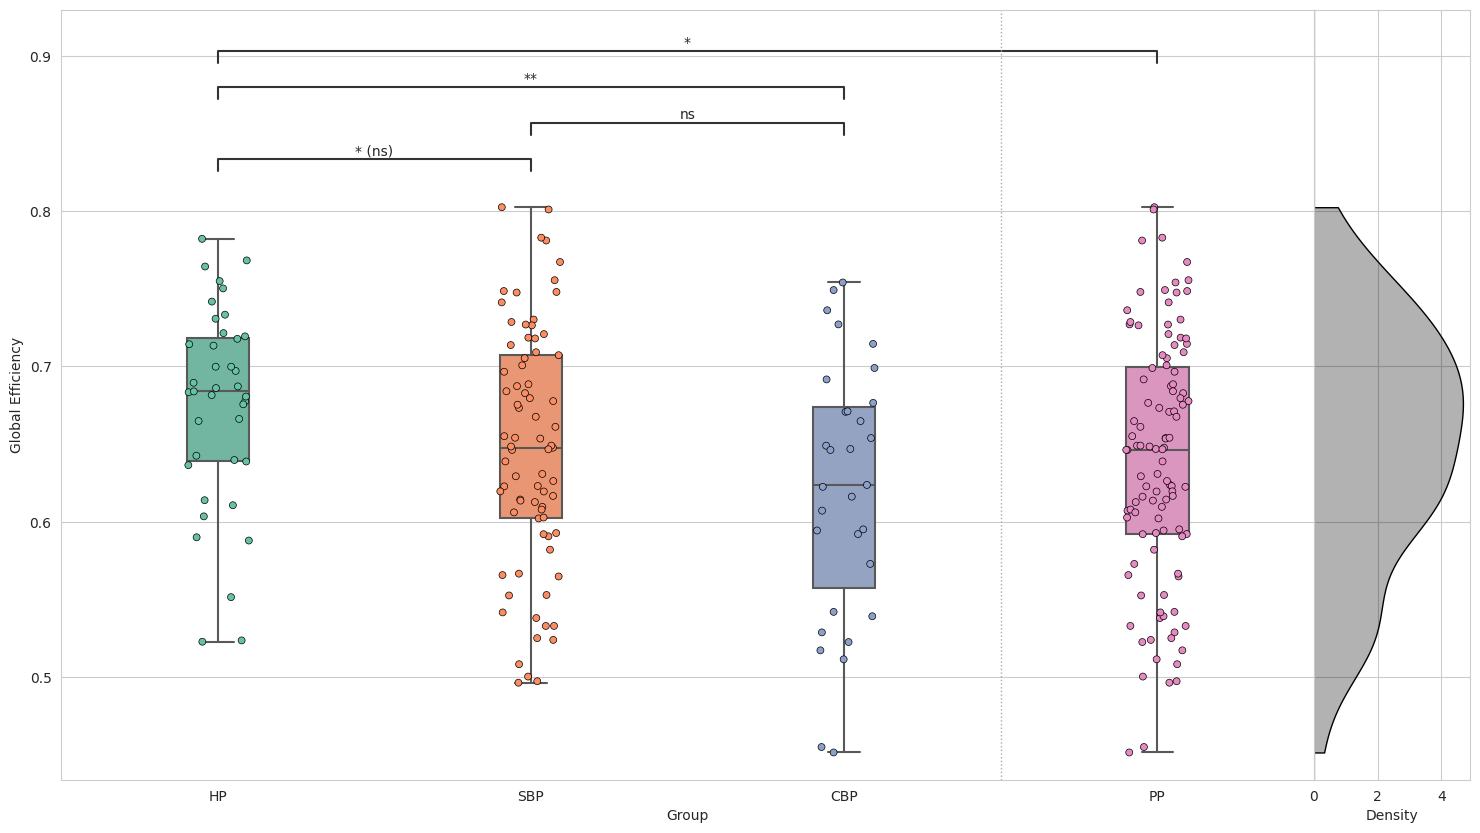

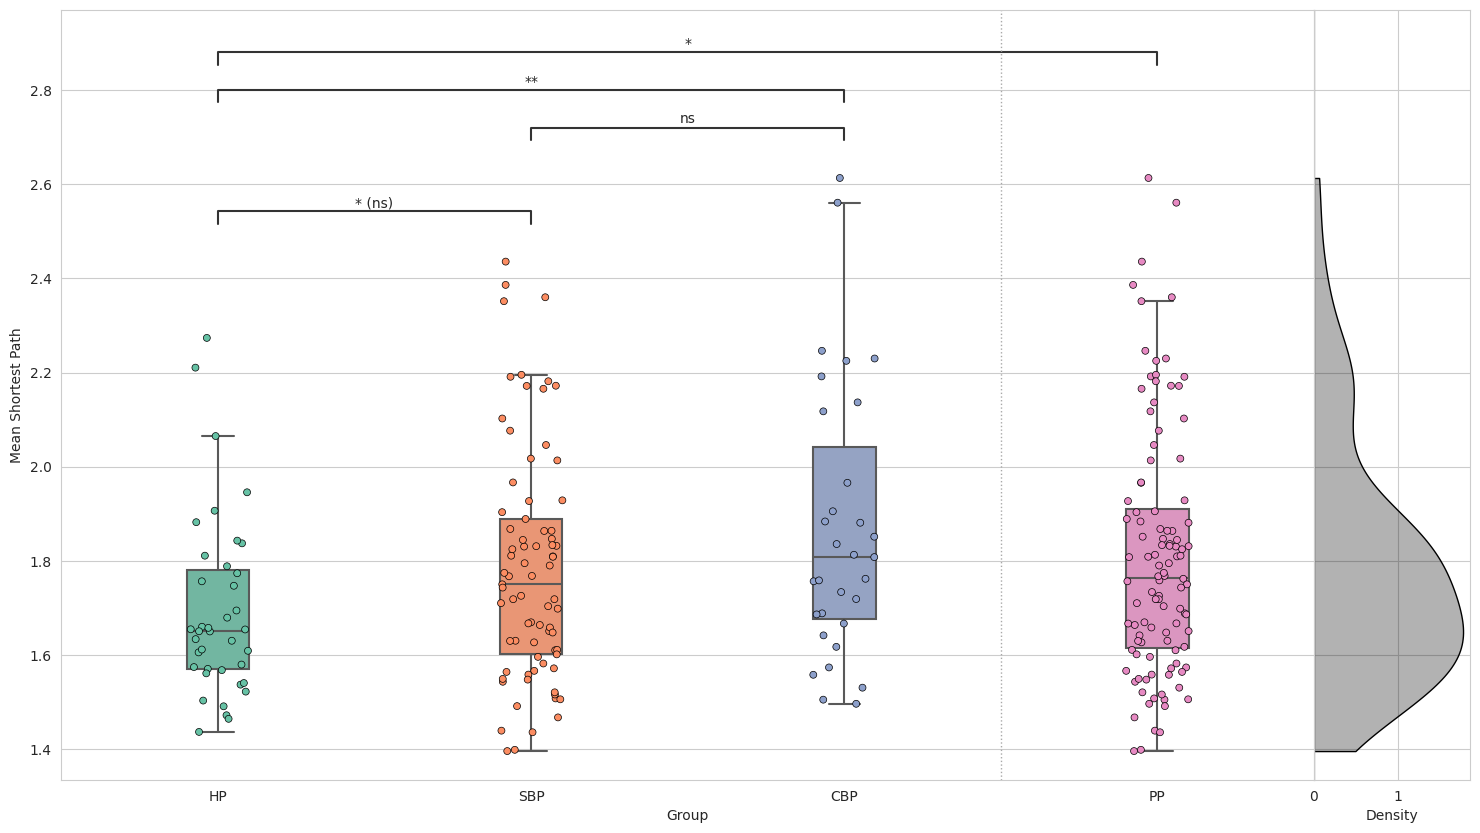

In [34]:
# make raincludplots for the graph features of very much interest
# mean node degree is on the y axis
# group is on the x axis

index_multi = pd.MultiIndex.from_product(
    [graph_features_of_special_interest, pairs_str])
results_graph_df = pd.DataFrame(index=index_multi, columns=[
                                'df', 't', 'p', 'cohens_d'])

analysis_df['Group'] = analysis_df['Subgroup'].apply(
    lambda x: 'PP' if x != 'HP' else 'HP')

for col in graph_features_of_special_interest:
    # make figure with 3 subplots, widtthrato 4:1:1
    fig, (ax, ax_all) = plt.subplots(1, 2, figsize=(20, 10),
                                     gridspec_kw={'width_ratios': [8, 1]}, sharey=True)

    ax_all.set_position([ax.get_position().x1, ax.get_position(
    ).y0, ax_all.get_position().width, ax_all.get_position().height])

    # this is a weired dataframe. PP subjects are double, because we want to have them as extra group. Kind of a hack, but it is easier to plot it this way
    df_for_this_plot = analysis_df.loc[analysis_df.Group == 'PP', [
        col, 'Group']].reset_index()
    df_for_this_plot = pd.concat([df_for_this_plot, analysis_df.loc[:, [col, 'Subgroup']].set_axis(
        [col, 'Group'], axis=1).set_axis(range(len(df_for_this_plot), len(df_for_this_plot)+len(analysis_df)), axis=0)])

    # make the boxplot
    sns.boxplot(data=df_for_this_plot, x='Group', y=col, ax=ax, width=0.2,
                order=order_for_this_plot, palette='Set2', showfliers=False)
    # make the stripplot
    sns.stripplot(data=df_for_this_plot, x='Group', y=col, ax=ax,
                  jitter=0.1, palette='Set2', order=order_for_this_plot,
                  edgecolor='black', linewidth=0.5)

    # make the annotation
    annotator = Annotator(ax, data=df_for_this_plot, x="Group",
                          y=col, order=order_for_this_plot, pairs=pairs)
    annotator.configure(test='t-test_ind',
                        comparisons_correction='fdr_bh',
                        )
    annot = annotator.apply_and_annotate()

    # mnake the kdeplot for all subjects
    sns.kdeplot(data=analysis_df, y=col, ax=ax_all,
                color='black', cut=0, linewidth=1, shade=True, alpha=0.3)

    # make a vertical dotted line between CBP and PP
    ax.axvline(x=2.5, color='darkgrey', linestyle='dotted', linewidth=1)

    # and a solid one at Density == 0
    ax_all.axvline(x=0, color='darkgrey', linestyle='solid', linewidth=1)
    ax_all.set_ylabel('')

    # set the y-label as converted with label_translation_graph_feature
    ax.set_ylabel(label_translation_graph_feature[col])

    # save the figure in network_second_level as svg
    fig.savefig(os.path.join(figure_network_sl_folder,
                             f'graph_feature_{col}_group.svg'), dpi=300)


In [35]:
# Calculate the stats for all graph features of medium interest for the table

index_multi = pd.MultiIndex.from_product(
    [graph_features_of_medium_interest, pairs_str])
results_graph_df = pd.DataFrame(index=index_multi, columns=[
                                'df', 't', 'p', 'cohens_d'])

# get PP as extra group
analysis_df['Group'] = analysis_df['Subgroup'].apply(
    lambda x: 'PP' if x != 'HP' else 'HP')

for col in graph_features_of_medium_interest:
        # this is a weired dataframe. PP subjects are double. But it is easier to plot it this way
    df_for_this_plot = analysis_df.loc[analysis_df.Group == 'PP', [
        col, 'Group']].reset_index()
    df_for_this_plot = pd.concat([df_for_this_plot, analysis_df.loc[:, [col, 'Subgroup']].set_axis(
        [col, 'Group'], axis=1).set_axis(range(len(df_for_this_plot), len(df_for_this_plot)+len(analysis_df)), axis=0)])

    for pair in pairs:
        # calculate the t-test
        t, p = stats.ttest_ind(df_for_this_plot.loc[df_for_this_plot.Group == pair[0], col],
                               df_for_this_plot.loc[df_for_this_plot.Group == pair[1], col])

        # calculate the other stats
        df = len(df_for_this_plot.loc[df_for_this_plot.Group == pair[0], col]) + len(
            df_for_this_plot.loc[df_for_this_plot.Group == pair[1], col]) - 2
        mean_1 = df_for_this_plot.loc[df_for_this_plot.Group == pair[0], col].mean(
        )
        mean_2 = df_for_this_plot.loc[df_for_this_plot.Group == pair[1], col].mean(
        )
        std_1 = df_for_this_plot.loc[df_for_this_plot.Group == pair[0], col].std(
        )
        std_2 = df_for_this_plot.loc[df_for_this_plot.Group == pair[1], col].std(
        )
        cohens_d = (mean_1 - mean_2) / np.sqrt((std_1**2 + std_2**2)/2)
        results_graph_df.loc[(col, '-'.join(pair)), :] = [df, t, p, cohens_d]

# now add a column with p_adj
for col in graph_features_of_medium_interest:
    results_graph_df.loc[col, 'p_adj'] = multipletests(
        results_graph_df.loc[col, 'p'], method='fdr_bh')[1]

# get the results in a nice format
results_graph_df = results_graph_df.astype(float)
results_graph_df = results_graph_df.loc[:, [
    'df', 't', 'cohens_d', 'p', 'p_adj']]

# results_graph_df.select_dtypes(include='float') =
results_graph_df = results_graph_df.applymap(
    lambda x: "{:.3f}".format(np.round(x, 3)))
results_graph_df = results_graph_df.reset_index()
results_graph_df.loc[:, 'level_1'] = [
    x.replace('-', ' vs ') for x in results_graph_df.loc[:, 'level_1']]
results_graph_df


,level_0,level_1,df,t,cohens_d,p,p_adj
0,global_efficiency,SBP vs HP,114.000,-1.991,-0.403,0.049,0.065
1,global_efficiency,CBP vs HP,68.000,-3.116,-0.739,0.003,0.011
2,global_efficiency,CBP vs SBP,106.000,-1.555,-0.326,0.123,0.123
3,global_efficiency,PP vs HP,145.000,-2.554,-0.500,0.012,0.023
4,mean_shortest_path,SBP vs HP,114.000,2.017,0.412,0.046,0.061
5,mean_shortest_path,CBP vs HP,68.000,3.031,0.712,0.003,0.014
6,mean_shortest_path,CBP vs SBP,106.000,1.530,0.313,0.129,0.129
7,mean_shortest_path,PP vs HP,145.000,2.518,0.503,0.013,0.026
8,small_world,SBP vs HP,114.000,1.777,0.363,0.078,0.078
9,small_world,CBP vs HP,68.000,3.148,0.739,0.002,0.010


***Figure 1A***

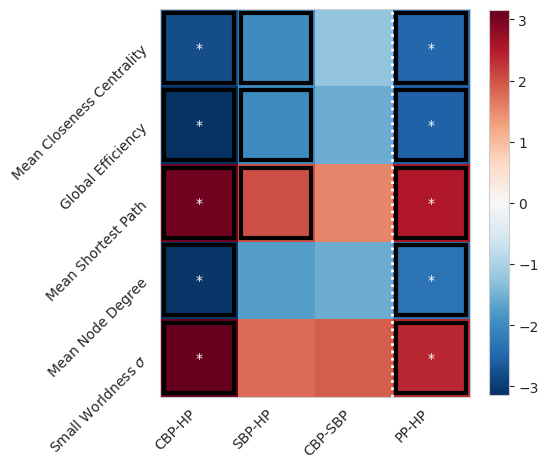

In [36]:
# just edit the index a little bit
results_graph_df.loc[:, 'level_1'] = [
    x.replace(' vs ', '-') for x in results_graph_df.loc[:, 'level_1']]
results_graph_df = results_graph_df.set_index(['level_0', 'level_1'])

# plot the pairwise t-tests for the graph features of medium interest as heatmap

# unstack results_graph_df. We need one unstacked version with the t values and one with the p values and one with the p_adj values

results_graph_df_t = results_graph_df['t'].unstack().sort_index(
    axis=1, level=1).loc[:, pair_order].astype(float)
results_graph_df_p = results_graph_df['p'].unstack().sort_index(
    axis=1, level=1).loc[:, pair_order].astype(float)
results_graph_df_p_adj = results_graph_df['p_adj'].unstack().sort_index(
    axis=1, level=1).loc[:, pair_order].astype(float)

# mow plot the results using ax.imshow
# plot the t values with a diverging colormap. center the colormap at 0 max and min are np.abs(t).max() and -np.abs(t).max()

fig, ax = plt.subplots(1, 1, figsize=(5, 10))
im = ax.imshow(results_graph_df_t, cmap='RdBu_r', vmin=-np.abs(
    results_graph_df_t).max().max(), vmax=np.abs(results_graph_df_t).max().max())

# remove gridlines
ax.grid(False)

# add a vertical white line between 'SBP-CBP and 'PP-HP', dotted
ax.axvline(x=2.5, color='white', linestyle='dotted', linewidth=2)

# add yticklabels. Take the index of the results_graph_df_t but convert it using label_translation_graph_feature
ax.set_yticks(range(len(results_graph_df_t.index)))
ax.set_yticklabels(
    label_translation_graph_feature[results_graph_df_t.index], rotation=45, ha='right')

# add xticklabels. Take the index of the results_graph_df_t
ax.set_xticks(range(len(results_graph_df_t.columns)))
ax.set_xticklabels(results_graph_df_t.columns, rotation=45, ha='right')

# add colorbar to ax_cbar that is smaller that the hight of the heatmap
cbar = fig.colorbar(im, orientation='vertical', shrink=.5)

# now make a black frame around every square of the heatmap where the p-value is below 0.05
for j in range(len(graph_features_of_medium_interest)):
    for i in range(len(pair_order)):
        # if uncorrected p-value is below 0.05 make a black frame around the square
        if results_graph_df_p.iloc[j, i] < 0.05:
            rect = patches.Rectangle(
                (i-0.45, j-0.45), .9, .9, linewidth=3, edgecolor='k', facecolor='none')
            ax.add_patch(rect)
            # now add stars to the square depending on the adjusted p-value
            # if it is below .001 put three stars in the square
            if results_graph_df_p_adj.iloc[j, i] < 0.001:
                ax.text(i, j, '***', ha='center', va='center', color='w')
            # if it is below .01 put two stars in the square
            elif results_graph_df_p_adj.iloc[j, i] < 0.01:
                ax.text(i, j, '**', ha='center', va='center', color='w')
            # if it is below .05 put one star in the square
            elif results_graph_df_p_adj.iloc[j, i] < 0.05:
                ax.text(i, j, '*', ha='center', va='center', color='w')

# save fig in the figure folder for networks second level as svg
fig.savefig(os.path.join(figure_network_sl_folder,
                         'networks_group_graph_features_all_second_level.svg'), bbox_inches='tight')


## Main Analysis

In [37]:
# the following analysis don not use the HC group. For convenience we will create a new dataframe without the HC group
analysis_df_PP = analysis_df[analysis_df['Subgroup'].isin(['CBP', 'SBP'])]


***Table 3***

In [38]:
# prepare dataframes to store the results
ols_t_results = pd.DataFrame(
    index=graph_features_of_medium_interest, columns=['pain_duration'])
ols_p_results = pd.DataFrame(
    index=graph_features_of_medium_interest, columns=['pain_duration'])
ols_coef_results = pd.DataFrame(
    index=graph_features_of_medium_interest, columns=['pain_duration'])
ols_std_results = pd.DataFrame(
    index=graph_features_of_medium_interest, columns=['pain_duration'])
ols_R2_results = pd.DataFrame(
    index=graph_features_of_medium_interest, columns=[['R2', 'R2_adj', 'p_F']])
model_series = pd.Series(index=graph_features_of_medium_interest)

for graph_feature in graph_features_of_medium_interest:
    # define the model
    model_df = analysis_df_PP.loc[:, [
        graph_feature, 'pain_duration', 'Gender']].copy()
    model_df = model_df.apply(stats.zscore)
    model_df.loc[:, 'Gender'] = analysis_df.loc[:, 'Gender']

    formula = f'{graph_feature} ~  pain_duration + Gender'
    model = smf.ols(formula=formula, data=model_df).fit()

    # add the pain_duration params to the dataframes
    ols_t_results.loc[graph_feature,
                      'pain_duration'] = model.tvalues['pain_duration']
    ols_p_results.loc[graph_feature,
                      'pain_duration'] = model.pvalues['pain_duration']
    ols_coef_results.loc[graph_feature,
                         'pain_duration'] = model.params['pain_duration']
    ols_std_results.loc[graph_feature,
                        'pain_duration'] = model.bse['pain_duration']

    # add the C(Gender) params to the dataframes
    # statsmodels chenges the name of variables, when they are categorical. We need to find the new name
    for idx in model.tvalues.index:
        if 'Gender' in idx:
            gender_var_name = idx
    ols_t_results.loc[graph_feature, 'Gender'] = model.tvalues[gender_var_name]
    ols_p_results.loc[graph_feature, 'Gender'] = model.pvalues[gender_var_name]
    ols_coef_results.loc[graph_feature,
                         'Gender'] = model.params[gender_var_name]
    ols_std_results.loc[graph_feature, 'Gender'] = model.bse[gender_var_name]

    # add the model results to the dataframes
    ols_R2_results.loc[graph_feature, 'R2'] = model.rsquared
    ols_R2_results.loc[graph_feature, 'R2_adj'] = model.rsquared_adj
    ols_R2_results.loc[graph_feature, 'p_F'] = model.f_pvalue

    # add the model to the model_series
    model_series.loc[graph_feature] = model

# convert all to float
ols_t_results = ols_t_results.astype(float)
ols_p_results = ols_p_results.astype(float)
ols_coef_results = ols_coef_results.astype(float)

# do FDR correction
ols_p_results_adj = ols_p_results.apply(
    lambda x: multipletests(x, method='fdr_bh')[1])

# make a nice formatted table
# copy and get only the first three digits
ols_results_summary_table = ols_coef_results.copy().applymap(
    lambda x: f'{x:.3f}').T

# add a star if p<.05 two if p<.01 and three if p<.001
for col in ols_results_summary_table.columns:
    for row in ols_results_summary_table.index:
        if ols_p_results_adj.loc[col, row] < 0.001:
            ols_results_summary_table.loc[row, col] += '***'
        elif ols_p_results_adj.loc[col, row] < 0.01:
            ols_results_summary_table.loc[row, col] += '**'
        elif ols_p_results_adj.loc[col, row] < 0.05:
            ols_results_summary_table.loc[row, col] += '*'
        elif ols_p_results_adj.loc[col, row] < 0.1:
            ols_results_summary_table.loc[row, col] += '°'

# add the std in brackets behind the coef-values
for col in ols_results_summary_table.columns:
    for row in ols_results_summary_table.index:
        ols_results_summary_table.loc[row,
                                      col] += f' ({ols_std_results.loc[col, row]:.3f})'

# add the ols_R2_results.columns to the index of ols_results_summary_table
ols_results_summary_table = ols_results_summary_table.T

# FDR correction for the p_F values
ols_R2_results.loc[:, 'p_F'] = multipletests(
    ols_R2_results.loc[:, 'p_F'].to_numpy().flatten(), method='fdr_bh')[1]

ols_R2_results = ols_R2_results.applymap(lambda x: f'{x:.3f}')
printmd(pd.concat([ols_results_summary_table,
                   ols_R2_results], axis=1).T.to_markdown())


/tmp/ipykernel_2434536/3794728566.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  model_series = pd.Series(index=graph_features_of_medium_interest)


|               | global_efficiency   | mean_shortest_path   | small_world     | node_degree_WB   | closeness_centrality   |
|:--------------|:--------------------|:---------------------|:----------------|:-----------------|:-----------------------|
| pain_duration | -0.263** (0.086)    | 0.269** (0.086)      | 0.172° (0.094)  | -0.287** (0.090) | -0.244** (0.089)       |
| Gender        | 0.764*** (0.180)    | -0.754*** (0.180)    | -0.494* (0.195) | 0.550** (0.187)  | 0.650** (0.186)        |
| ('R2',)       | 0.234               | 0.233                | 0.099           | 0.176            | 0.181                  |
| ('R2_adj',)   | 0.219               | 0.219                | 0.081           | 0.160            | 0.165                  |
| ('p_F',)      | 0.000               | 0.000                | 0.004           | 0.000            | 0.000                  |

***Figure 2A***

/gxfs_home/cau/suknp018/miniconda3/envs/B03_virtenv/lib/python3.11/site-packages/seaborn/distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/gxfs_home/cau/suknp018/miniconda3/envs/B03_virtenv/lib/python3.11/site-packages/seaborn/distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '')

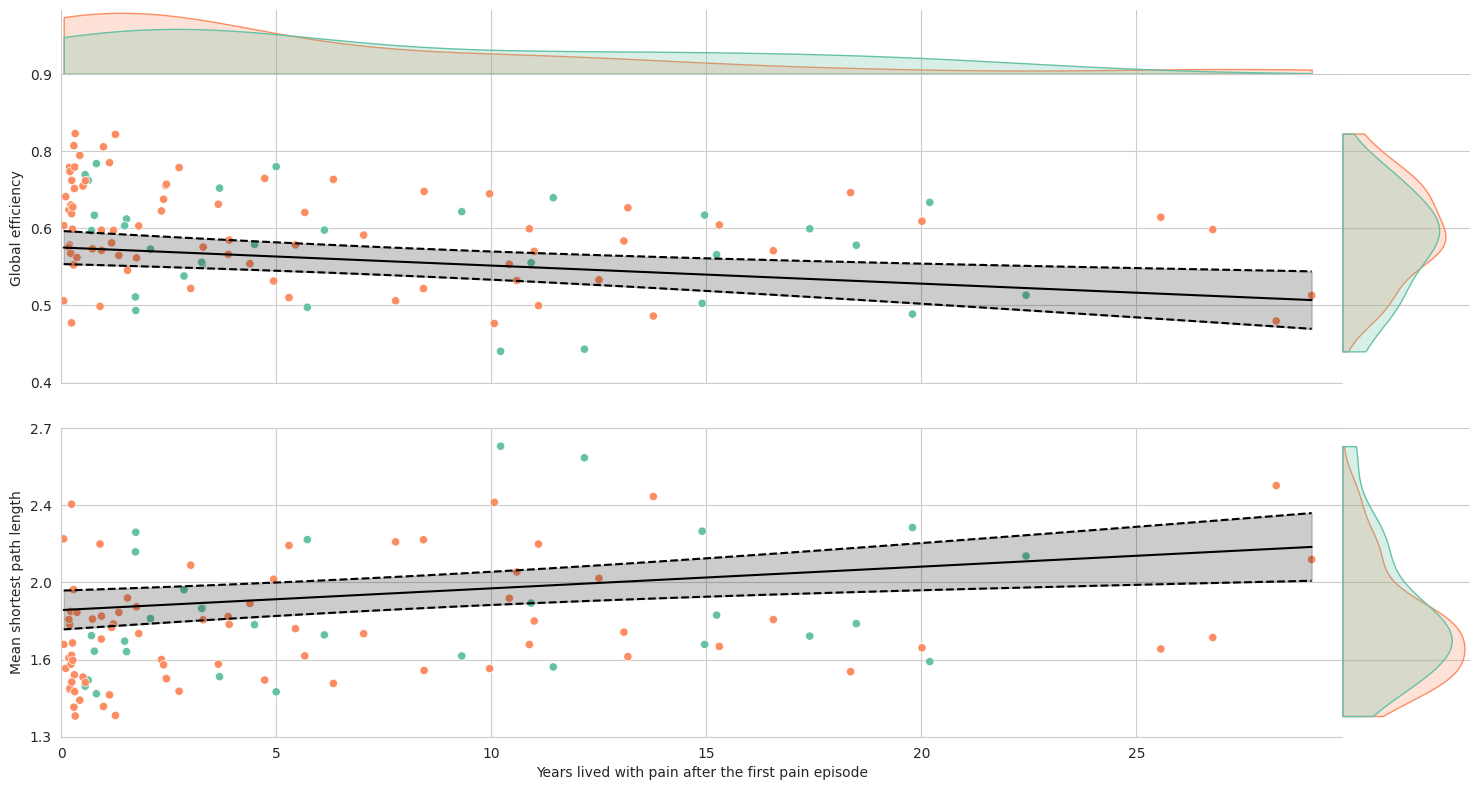

In [39]:
# make a scatterplot with a lmplot for the regressions with 'global_efficiency' as y and 'pain_durtion' as x

# basic figure preparation
fig, axes = plt.subplots(3, 2, figsize=(20, 10), width_ratios=[
                         1, 0.1], height_ratios=[.2, 1, 1], sharex='col', sharey='row')
ax_lm_ge = axes[1, 0]
ax_lm_msp = axes[2, 0]
ax_kde_paindur = axes[0, 0]
ax_kde_ge = axes[1, 1]
ax_kde_msp = axes[2, 1]
axes[0, 1].set_visible(False)

# make a dataframe with the necessary data for the plot (zscored data and Subgroup)
df_PP = analysis_df_PP.select_dtypes(np.number).apply(stats.zscore)
df_PP['Subgroup'] = analysis_df_PP['Subgroup']

# plot the basic plots
# plot the scatterplots
sns.scatterplot(data=df_PP, x='pain_duration', y='global_efficiency',
                hue='Subgroup', palette=cmap, ax=ax_lm_ge, legend=False)
sns.scatterplot(data=df_PP, x='pain_duration', y='mean_shortest_path',
                hue='Subgroup', palette=cmap, ax=ax_lm_msp, legend=False)

# plot the kdeplots and cut them off at min and max values
sns.kdeplot(data=df_PP, x='pain_duration', hue='Subgroup', palette=cmap,
            ax=ax_kde_paindur, legend=False, fill=True, common_norm=False, common_grid=True, cut=0)
sns.kdeplot(data=df_PP, x='global_efficiency', hue='Subgroup', palette=cmap, ax=ax_kde_ge,
            legend=False, fill=True, common_norm=False, common_grid=True, cut=0, vertical=True)
sns.kdeplot(data=df_PP, x='mean_shortest_path', hue='Subgroup', palette=cmap, ax=ax_kde_msp,
            legend=False, fill=True, common_norm=False, common_grid=True, cut=0, vertical=True)

# plot the regression lines
# get the model for the regression
model_ge = model_series['global_efficiency']
model_msp = model_series['mean_shortest_path']

# make a linesapce for the x values and a prediction dataframe
linespace_n = 100
x_pred = np.linspace(df_PP.pain_duration.min(),
                     df_PP.pain_duration.max(), linespace_n)
gender_mean = np.array([np.mean(df_PP.Gender)]*linespace_n)
pred_df = pd.DataFrame({'pain_duration': x_pred, 'Gender': gender_mean})

pred_ge = model_ge.get_prediction(pred_df).summary_frame()
pred_msp = model_msp.get_prediction(pred_df).summary_frame()

# plot the regression lines
ax_lm_ge.plot(x_pred, pred_ge['mean'], color='k')
ax_lm_msp.plot(x_pred, pred_msp['mean'], color='k')

# plot the confidence intervals with shaded areas with the borers beeing dotted lines
ax_lm_ge.fill_between(x_pred, pred_ge['mean_ci_lower'],
                      pred_ge['mean_ci_upper'], color='k', alpha=.2, label='95% CI')
ax_lm_ge.plot(x_pred, pred_ge['mean_ci_lower'], color='k', linestyle='--')
ax_lm_ge.plot(x_pred, pred_ge['mean_ci_upper'], color='k', linestyle='--')

ax_lm_msp.fill_between(x_pred, pred_msp['mean_ci_lower'],
                       pred_msp['mean_ci_upper'], color='k', alpha=.2, label='95% CI')
ax_lm_msp.plot(x_pred, pred_msp['mean_ci_lower'], color='k', linestyle='--')
ax_lm_msp.plot(x_pred, pred_msp['mean_ci_upper'], color='k', linestyle='--')

# adapt the axes
# set the x and y limits to the max and min values of the data +-.1
ax_lm_ge.set_xlim(df_PP.pain_duration.min()-.1, df_PP.pain_duration.max()+.1)

# set the position of the kdeplots
# get the position of the axes
pos_ax_lm_ge = ax_lm_ge.get_position()
pos_ax_lm_msp = ax_lm_msp.get_position()
pos_ax_kde_paindur = ax_kde_paindur.get_position()
pos_ax_kde_ge = ax_kde_ge.get_position()
pos_ax_kde_msp = ax_kde_msp.get_position()
# set the new posaitions
ax_kde_paindur.set_position([pos_ax_lm_ge.x0, pos_ax_lm_ge.y0 +
                             pos_ax_lm_ge.height, pos_ax_lm_ge.width, pos_ax_kde_ge.width])
ax_kde_ge.set_position([pos_ax_lm_ge.x0 + pos_ax_lm_ge.width,
                        pos_ax_lm_ge.y0, pos_ax_kde_ge.width, pos_ax_lm_ge.height])
ax_kde_msp.set_position([pos_ax_lm_msp.x0 + pos_ax_lm_msp.width,
                         pos_ax_lm_msp.y0, pos_ax_kde_msp.width, pos_ax_lm_msp.height])

# remove the borders from the kdeplots
for ax in [ax_kde_ge, ax_kde_msp, ax_kde_paindur]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)


# rebrand the axis to unstandardized ticks and labels
# get the max and ceil them to the next 5
x_max = np.ceil(analysis_df_PP.pain_duration.max()/5)*5
# now make a list for the ticks where every 5th tick is labeled
x_ticks = np.arange(0, x_max+1, 5).astype(int)
# get the equivalent in z scores
x_ticks_z = (x_ticks - analysis_df_PP.pain_duration.mean()) / \
    analysis_df_PP.pain_duration.std()
# set the ticks and labels
ax_lm_ge.set_xticks(x_ticks_z)
ax_lm_ge.set_xticklabels(x_ticks)
# rename the x axis
ax_lm_msp.set_xlabel('Years lived with pain after the first pain episode')

# set x_min to 0
ax_lm_ge.set_xlim((0-analysis_df_PP.pain_duration.mean()) /
                  analysis_df_PP.pain_duration.std(), df_PP.pain_duration.max()+.1)

# get the min and max of the y axis. ceil them to the next .1
y_min_ge = np.floor(analysis_df_PP.global_efficiency.min()*10)/10
y_max_ge = np.ceil(analysis_df_PP.global_efficiency.max()*10)/10
# make a list for the ticks with totally 5 ticks
y_ticks_ge = np.linspace(y_min_ge, y_max_ge, 5)
# get the equivalent in z scores
y_ticks_ge_z = (y_ticks_ge - analysis_df_PP.global_efficiency.mean()
                ) / analysis_df_PP.global_efficiency.std()
# set the ticks and labels
ax_lm_ge.set_yticks(y_ticks_ge_z)
ax_lm_ge.set_yticklabels(np.around(y_ticks_ge, 1))
# rename the y axis
ax_lm_ge.set_ylabel('Global efficiency')

# get the min and max of the y axis. ceil them to the next .1
y_min_msp = np.floor(analysis_df_PP.mean_shortest_path.min()*10)/10
y_max_msp = np.ceil(analysis_df_PP.mean_shortest_path.max()*10)/10
# make a list for the ticks with totally 5 ticks
y_ticks_msp = np.linspace(y_min_msp, y_max_msp, 5)
# get the equivalent in z scores
y_ticks_msp_z = (y_ticks_msp - analysis_df_PP.mean_shortest_path.mean()
                 )/analysis_df_PP.mean_shortest_path.std()
# set the ticks and labels
ax_lm_msp.set_yticks(y_ticks_msp_z)
ax_lm_msp.set_yticklabels(np.around(y_ticks_msp, 1))
# rename the y axis
ax_lm_msp.set_ylabel('Mean shortest path length')


# make kdeplots more beautiful
# for all kde plots remove the density ticks and labels
for ax in [ax_kde_ge, ax_kde_msp]:
    ax.set_xticks([])
    ax.set_xlabel('')

ax_kde_paindur.set_yticks([])
ax_kde_paindur.set_ylabel('')


Now we make the same node and edgewise

In [40]:
# edgewise

# some preparations
connectome_dmn_idx = np.array(
    difumo_atlas_networks) == 'DefaultB'  # get DMN indices
connectome_dmn_coords = coords[connectome_dmn_idx]  # get DMN coordinates
PP_idx = feature_df.Subgroup != 'HP'

# standardize connectomes
connectomes_pearson_z_vec = stats.zscore(
    sym_matrix_to_vec(connectomes_pearson), axis=1)
connectomes_pearson_z = vec_to_sym_matrix(connectomes_pearson_z_vec)

# get the default mode network connectome
connectomes_pearson_default = connectomes_pearson_z[:,
                                                    connectome_dmn_idx, :][:, :, connectome_dmn_idx]
# vectorize it
connectomes_pearson_default_vec = sym_matrix_to_vec(
    connectomes_pearson_default, discard_diagonal=True)

# for the ols get the predictor variables
X = stats.zscore(analysis_df.loc[PP_idx, ['pain_duration']])
X = X.join(analysis_df.Gender)

# get the dependent variable
y = stats.zscore(connectomes_pearson_default_vec[PP_idx])

# fit the model
reg = LinearRegression().fit(X, y)

# sklearn linear regression does not provide stats values, so we have to calculate them ourselves
sse = np.sum((y - reg.predict(X))**2, axis=0) / float(X.shape[0] - X.shape[1])
se = np.array([np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
               for i in range(sse.shape[0])])
t = reg.coef_ / se
p = 2 * (1 - stats.t.cdf(np.abs(t), y.shape[0] - X.shape[1]))

result_connectivity_df = pd.DataFrame({'coef': reg.coef_[:, 0],
                                       'se': se[:, 0],
                                       't': t[:, 0],
                                       'p': p[:, 0],
                                       # fdr corrected p values
                                       'p_adj': multipletests(p[:, 0], method='fdr_bh', alpha=.1)[1],
                                       }
                                      )
# convert back to matri, masked for p values > .1
coef_p_adj_masked = vec_to_sym_matrix(
    result_connectivity_df.coef, diagonal=np.full(connectome_dmn_idx.sum(), np.nan))
coef_p_adj_masked[vec_to_sym_matrix(result_connectivity_df.p_adj, diagonal=np.full(
    connectome_dmn_idx.sum(), np.nan)) > .1] = np.nan


Now nodewise

In [41]:
# get the node degrees
node_degree = np.vstack(analysis_df.node_degree.to_list())
node_degree_PP = node_degree[PP_idx, :]

# get the dependent variable and standardize them
y = stats.zscore(node_degree_PP, axis=0)

# fit the model
reg_node = LinearRegression().fit(X, y)

# sklearn linear regression does not provide stats values, so we have to calculate them ourselves
sse_node = np.sum((y - reg_node.predict(X))**2, axis=0) / \
    float(X.shape[0] - X.shape[1])
se_node = np.array([np.sqrt(np.diagonal(
    sse_node[i] * np.linalg.inv(np.dot(X.T, X))))for i in range(sse_node.shape[0])])
t_node = reg_node.coef_ / se_node
p_node = 2 * (1 - stats.t.cdf(np.abs(t_node), y.shape[0] - X.shape[1]))

result_node_df = pd.DataFrame({'coef': reg_node.coef_[:, 0],
                               'se': se_node[:, 0],
                               't': t_node[:, 0],
                               'p': p_node[:, 0],
                               'p_adj': multipletests(p_node[:, 0], method='fdr_bh', alpha=.05)[1],
                               'coords': [list(coordinates) for coordinates in connectome_dmn_coords],
                               }
                              )

result_node_df_masked = result_node_df.copy()
result_node_df_masked_inverted = result_node_df.copy()
for idx in range(len(result_node_df_masked)):
    if result_node_df_masked.p_adj[idx] > .1:
        result_node_df_masked = result_node_df_masked.drop(idx)
    else:
        result_node_df_masked_inverted = result_node_df_masked_inverted.drop(
            idx)


***Figure 2C***

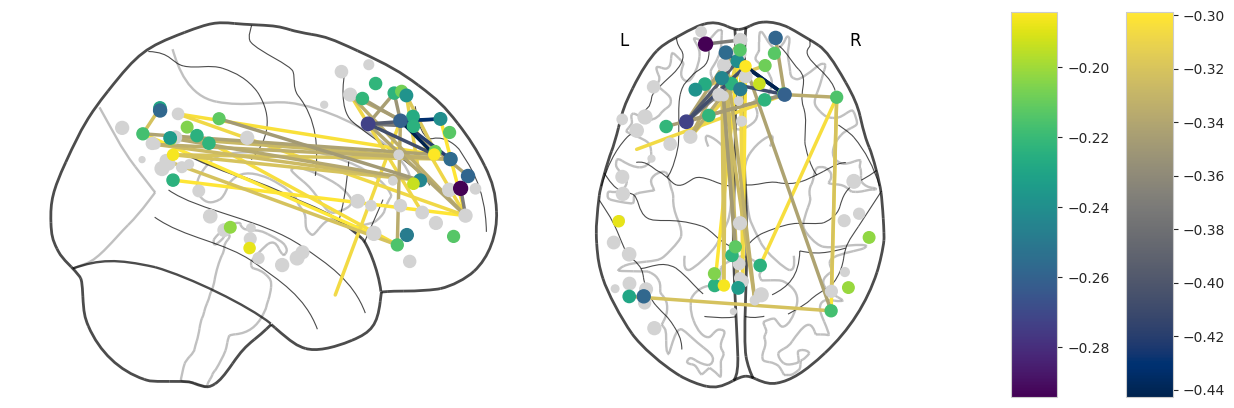

In [42]:

# plot the results

fig, (ax, ax_node_cmap, ax_edge_cmap) = plt.subplots(
    1, 3, figsize=(15, 5), width_ratios=[1, .05, .05])

display = nplot.plot_glass_brain(None, display_mode='xz', axes=ax,)

display.add_graph(coef_p_adj_masked, node_coords=connectome_dmn_coords, node_size=0,
                  edge_cmap='cividis', edge_vmin=np.nanmin(coef_p_adj_masked), edge_vmax=np.nanmax(coef_p_adj_masked),
                  edge_kwargs={'linewidth': 2.5})


node_sizes_non_sig = np.abs(result_node_df_masked_inverted.coef) / \
    np.max(np.abs(result_node_df_masked_inverted.coef)) * 100

# add the non significant in grey
display.add_markers(np.vstack(result_node_df_masked_inverted.coords),
                    marker_color='lightgrey', marker_size=node_sizes_non_sig,)

node_sizes = np.abs(result_node_df_masked.coef) / \
    np.max(np.abs(result_node_df_masked.coef)) * 100
display.add_markers(np.vstack(result_node_df_masked.coords),
                    marker_color=result_node_df_masked.coef, marker_size=node_sizes, cmap='viridis')


# add black borfer to the nodes
for node in ax.collections[1:]:
    node.set_edgecolor('black')
    node.set_linewidth(4)

# reproduce the cmap from the plot above
edge_cmap = plt.cm.cividis
edge_norm = plt.Normalize(vmin=np.nanmin(
    coef_p_adj_masked), vmax=np.nanmax(coef_p_adj_masked))
edge_sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=edge_norm)
edge_sm.set_array([])
edge_cbar = plt.colorbar(edge_sm, cax=ax_edge_cmap)

# same for the node cmap
node_cmap = plt.cm.viridis
node_norm = plt.Normalize(vmin=np.nanmin(
    result_node_df_masked.coef), vmax=np.nanmax(result_node_df_masked.coef))
node_sm = plt.cm.ScalarMappable(cmap=node_cmap, norm=node_norm)
node_sm.set_array([])
node_cbar = plt.colorbar(node_sm, cax=ax_node_cmap)


This were the OLS on network level models. Now we proceed with the SEM

In [43]:
# function to plot the SEM as a graph
def draw_SEM_as_G(mod_df, fig=None):

    plt.style.use('seaborn-whitegrid')

    # if fig is none create a new figure
    if fig is None:
        fig = plt.figure(figsize=(20, 15))
    # create a new ax
    ax = fig.add_subplot(111)

    lvals = mod_df.lval.unique()
    rvals = mod_df.rval.unique()
    vals = np.unique(np.concatenate((lvals, rvals)))

    mod_G = nx.DiGraph()
    mod_G.add_nodes_from(vals)

    for i in range(len(mod_df)):
        mod_G.add_edge(mod_df.rval[i], mod_df.lval[i],
                       weight=mod_df.Estimate[i])
        # add pvalues as edge attribute
        pval = mod_df['p-value'][i]
        if not pval == '-':
            mod_G.edges[mod_df.rval[i], mod_df.lval[i]]['pvalue'] = pval
        else:
            mod_G.edges[mod_df.rval[i], mod_df.lval[i]]['pvalue'] = 1

    # delete self loops
    mod_G.remove_edges_from(nx.selfloop_edges(mod_G))

    # get a Graph with only the edges of interest
    mod_G_interest = mod_G.edge_subgraph(edges_of_interest)
    print(mod_G.nodes)

    # mod G not that interesting
    mod_G_not_that_interesting = mod_G.edge_subgraph(
        list(set(mod_G.edges) - set(mod_G_interest.edges)))

    # get weights as dict
    weights = nx.get_edge_attributes(mod_G_interest, 'weight')

    nice_label_dict_for_this_plot = nice_label_dict.copy()
    # drop all labels that are not in the graph
    for key in nice_label_dict_for_this_plot.copy():
        if not key in mod_G.nodes:
            nice_label_dict_for_this_plot.pop(key)

    # draw the edges of the mode_G_interest Graph
    nx.draw_networkx(mod_G_interest, pos=pos_dict, ax=ax, width=[np.abs(weights[i])*10 for i in weights], edge_color=[weights[i] for i in weights], arrowsize=20,
                     edge_cmap=plt.cm.coolwarm, edge_vmin=-np.abs(mod_df.Estimate.max()), edge_vmax=np.abs(mod_df.Estimate.max()), node_color=(0, 0, 0, 0), node_size=12000, labels=nice_label_dict_for_this_plot, font_size=20, node_shape='s')

    # draw the other edges
    nx.draw_networkx_edges(mod_G_not_that_interesting,
                           pos=pos_dict, ax=ax,  node_size=25000)

    # draw the measured variables nodes
    nx.draw_networkx_nodes(mod_G, nodelist=mod_G.nodes - latent_variables,
                           pos=pos_dict, ax=ax, node_color='lightblue', node_size=10000)

    latent_in_G = np.intersect1d(mod_G.nodes, latent_variables)
    # draw the latent variables nodes

    for latent in latent_in_G:
        # draw a rectangle around the latent variable
        ax.add_patch(Rectangle((pos_dict[latent][0]-.6, pos_dict[latent]
                                [1]-.5), 1.2, 1, linewidth=2, edgecolor='k', facecolor='white'))
        print(latent, ' got an patch')

    # add edge values and pvalues as stars to edges in the plot
    for i in mod_G.edges:
        p_val = mod_G.edges[i]['pvalue']
        if p_val < .001:
            text = '***'
        elif p_val < .01:
            text = '**'
        elif p_val < .05:
            text = '*'
        elif p_val < .1:
            text = '°'
        else:
            text = ''
        weight_text = round(mod_G.edges[i]['weight'], 2)
        if weight_text == 1:
            weight_text = int(weight_text)
        text = str(weight_text) + text

        # get the position of the middle of the edge
        x = (pos_dict[i[0]][0] + pos_dict[i[1]][0])/2
        y = (pos_dict[i[0]][1] + pos_dict[i[1]][1])/2
        # add text to the middle of the edge and underlay it with a white background
        ax.text(x, y, text, fontsize=12, color='black', horizontalalignment='center',
                verticalalignment='center', bbox=dict(facecolor='white', alpha=0.9, edgecolor='white', pad=8))

    # remove the grid
    ax.grid(False)

    return fig


***Figure 2B***

/tmp/ipykernel_2434536/4273653325.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/gxfs_home/cau/suknp018/miniconda3/envs/B03_virtenv/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


['Gender', 'closeness_centrality', 'dmn_perturbation', 'global_efficiency', 'mean_shortest_path', 'node_degree_WB', 'pain_duration', 'small_world']
dmn_perturbation  got an patch


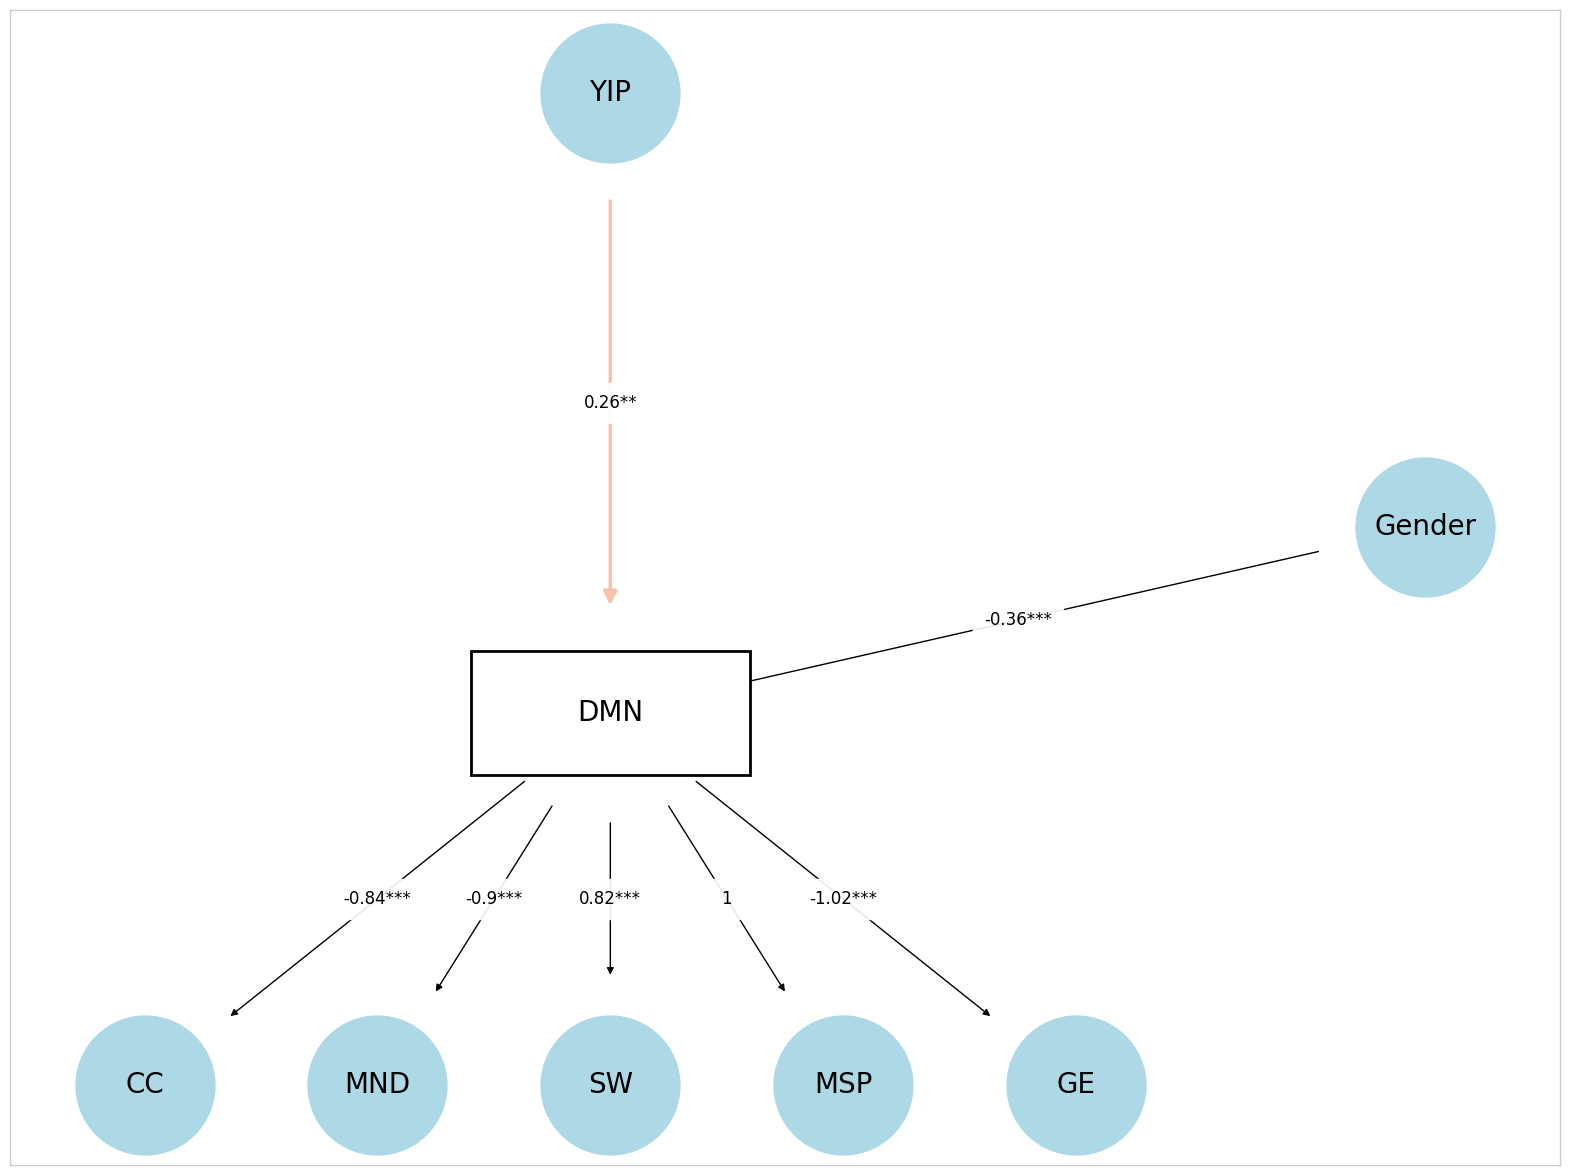

In [44]:
# define the SEM model
model = ''' 
            dmn_perturbation =~ mean_shortest_path + global_efficiency + node_degree_WB + small_world + closeness_centrality
            dmn_perturbation ~ pain_duration  +  Gender
            '''

# fit the model
mod = sem.Model(model)
res = mod.fit(df_PP.select_dtypes(np.number).apply(stats.zscore), obj='MLW')
mod_df1 = mod.inspect()
sem_stats_mod1 = sem.calc_stats(mod)

fig = draw_SEM_as_G(mod_df1)

fig.savefig(os.path.join(figure_network_sl_folder, 'SEM_mod1.svg'))


***Figure 3***

/tmp/ipykernel_2434536/4273653325.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


['Gender', 'closeness_centrality', 'coping', 'coping2', 'dmn_perturbation', 'fsk_helplesness', 'fsk_resourcefulness', 'fss_catastrophizing', 'fss_coping', 'global_efficiency', 'mean_shortest_path', 'node_degree_WB', 'pain_duration', 'small_world']
coping  got an patch
coping2  got an patch
dmn_perturbation  got an patch


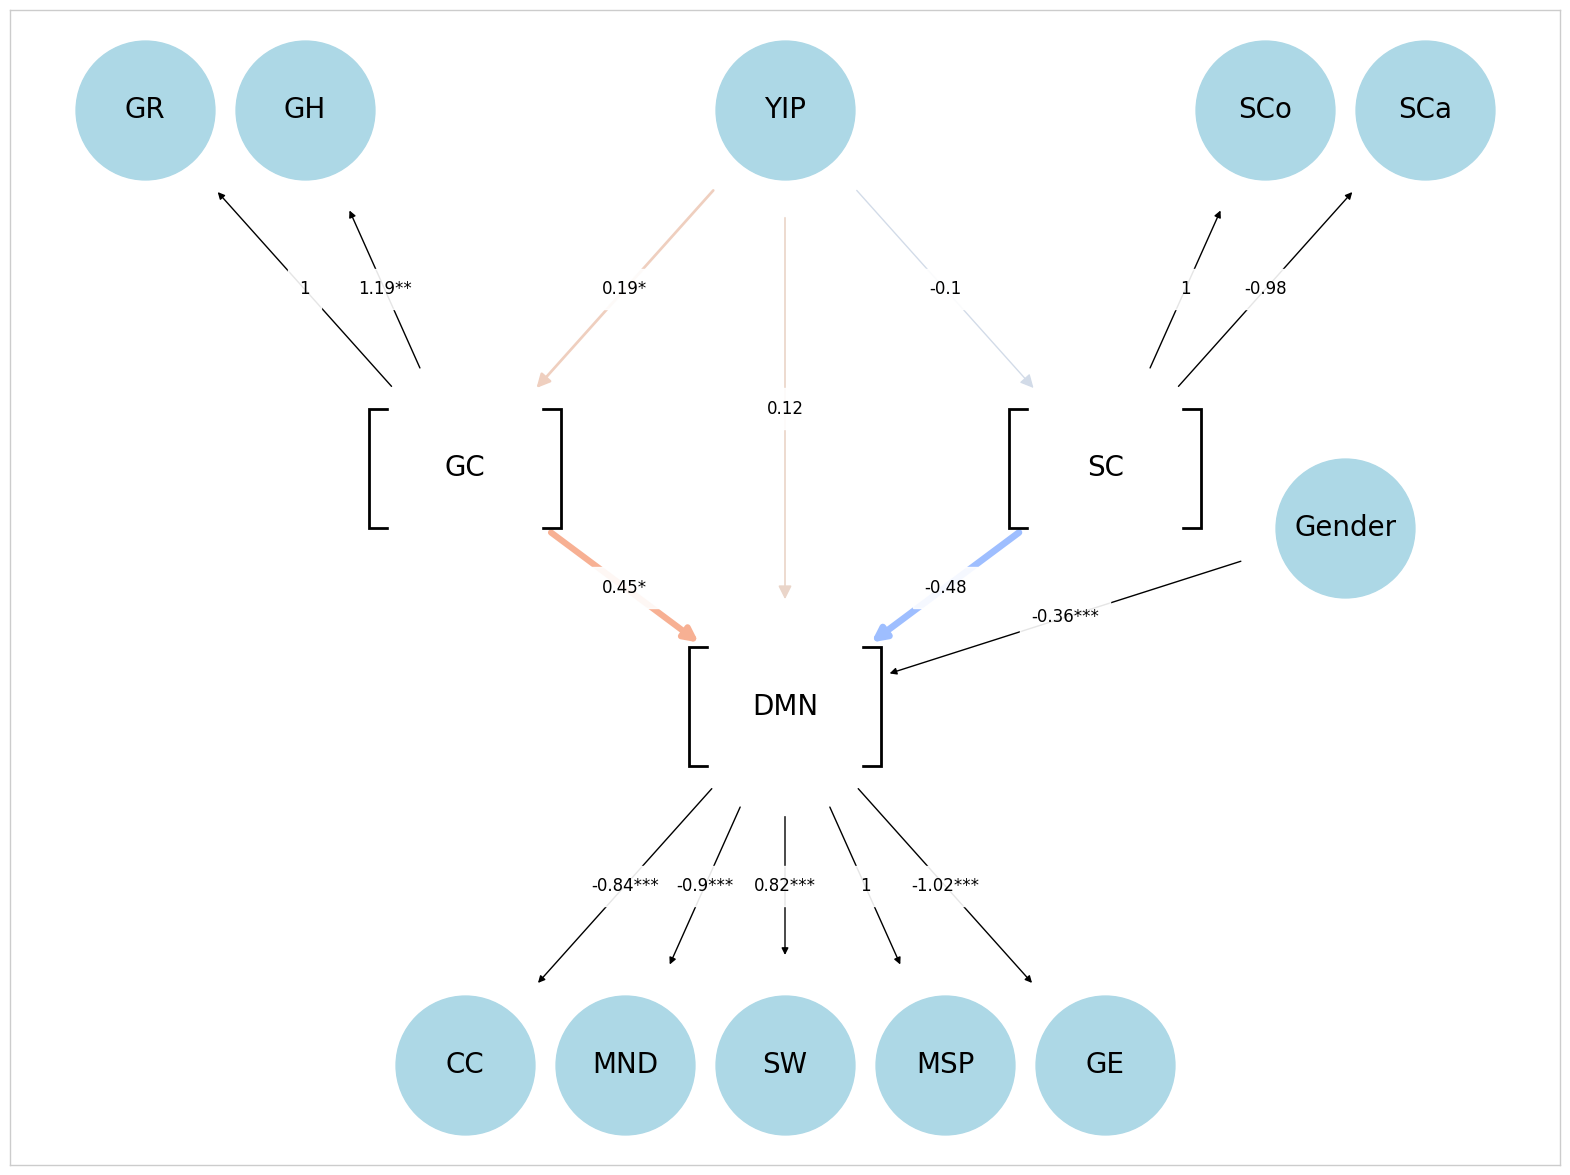

In [45]:
# I have pain_duration, fsk_helplesness and mean_node_degree as variables.
# Build a mediation model with pain_duration as predictor, fsk_helplesness as mediator and mean_node_degree as outcome variable. Usinmfg the semopy package.

# define the model
model = ''' dmn_perturbation =~ mean_shortest_path + global_efficiency + node_degree_WB + small_world + closeness_centrality    # the latent variable for DMN perturbation
            coping =~ fsk_resourcefulness + fsk_helplesness #+ 
            coping2 =~ fss_coping + fss_catastrophizing
            coping ~ pain_duration
            coping2 ~ pain_duration
            
            dmn_perturbation ~ coping  + pain_duration + Gender + coping2
            
            '''

# fit the model
mod = sem.Model(model, )

res = mod.fit(df_PP.select_dtypes(np.number).apply(stats.zscore), obj='MLW')
sem_stats_mod2 = sem.calc_stats(mod)
mod_df2 = mod.inspect()

fig = draw_SEM_as_G(mod_df2)
fig.savefig(os.path.join(figure_network_sl_folder, 'SEM_mod2.svg'))


***Table 4***

In [46]:
pd.DataFrame({'Model 1': sem_stats_mod1.T.iloc[:, 0], 'Model 2': sem_stats_mod2.T.iloc[:, 0]}).T.applymap(
    lambda x: round(x, 2))


,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Model 1,16.0,23.0,111.80,0.0,869.81,0.89,0.87,0.82,0.87,0.84,0.24,21.93,54.12,1.04
Model 2,42.0,57.0,160.11,0.0,964.97,0.87,0.83,0.77,0.83,0.82,0.16,45.03,109.41,1.48


In [47]:
# exchange the labels for all lval in mod_df2 and mod_df1

mod_df2.lval = [nice_label_dict[i] for i in mod_df2.lval]
mod_df2.rval = [nice_label_dict[i] for i in mod_df2.rval]

mod_df1.lval = [nice_label_dict[i] for i in mod_df1.lval]
mod_df1.rval = [nice_label_dict[i] for i in mod_df1.rval]


In [48]:
mod_df2 = mod_df2.replace('-', np.nan)
mod_df1 = mod_df1.replace('-', np.nan)

# make the columns Estimte Std. Err, z-value and p-value to numeric
mod_df2[['Estimate', 'Std. Err', 'z-value', 'p-value']
        ] = mod_df2[['Estimate', 'Std. Err', 'z-value', 'p-value']].apply(pd.to_numeric)
mod_df1[['Estimate', 'Std. Err', 'z-value', 'p-value']
        ] = mod_df1[['Estimate', 'Std. Err', 'z-value', 'p-value']].apply(pd.to_numeric)


In [49]:
mod_df2[mod_df2.select_dtypes(np.number).columns] = mod_df2.select_dtypes(
    np.number).applymap(lambda x: f'{np.round(x,3)}')
mod_df1[mod_df1.select_dtypes(np.number).columns] = mod_df1.select_dtypes(
    np.number).applymap(lambda x: f'{np.round(x,3)}')

# replace nan with '-'
mod_df2 = mod_df2.replace('nan', '-')
mod_df1 = mod_df1.replace('nan', '-')

# for the p-valuzes, replace the 0.0 with '<.001'
mod_df2['p-value'] = mod_df2['p-value'].replace('0.0', '<.001')
mod_df1['p-value'] = mod_df1['p-value'].replace('0.0', '<.001')


***Table S3***

In [50]:
mod_df1


,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,DMN,~,YIP,0.257,0.083,3.083,0.002
1,DMN,~,Gender,-0.359,0.084,-4.288,<.001
2,MSP,~,DMN,1.0,-,-,-
3,GE,~,DMN,-1.024,0.023,-44.727,<.001
4,MND,~,DMN,-0.905,0.05,-18.1,<.001
5,SW,~,DMN,0.822,0.061,13.417,<.001
6,CC,~,DMN,-0.837,0.059,-14.068,<.001
7,DMN,~~,DMN,0.731,0.104,7.013,<.001
8,CC,~~,CC,0.332,0.045,7.307,<.001
9,MND,~~,MND,0.22,0.03,7.222,<.001


***Table S4***

In [51]:
mod_df2


,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,GC,~,YIP,0.194,0.085,2.287,0.022
1,SC,~,YIP,-0.098,0.085,-1.148,0.251
2,DMN,~,GC,0.446,0.191,2.332,0.02
3,DMN,~,YIP,0.123,0.101,1.223,0.221
4,DMN,~,Gender,-0.362,0.08,-4.533,<.001
5,DMN,~,SC,-0.479,0.478,-1.003,0.316
6,MSP,~,DMN,1.0,-,-,-
7,GE,~,DMN,-1.024,0.023,-44.506,<.001
8,MND,~,DMN,-0.905,0.05,-18.001,<.001
9,SW,~,DMN,0.822,0.062,13.346,<.001


## Supplementary analysis

***Table S5***

In [52]:
# prepare dataframes to store the results
ols_t_results = pd.DataFrame(index=graph_features_of_medium_interest, columns=[
                             'pain_days_last_year'])
ols_p_results = pd.DataFrame(index=graph_features_of_medium_interest, columns=[
                             'pain_days_last_year'])
ols_coef_results = pd.DataFrame(
    index=graph_features_of_medium_interest, columns=['pain_days_last_year'])
ols_std_results = pd.DataFrame(
    index=graph_features_of_medium_interest, columns=['pain_days_last_year'])
ols_R2_results = pd.DataFrame(
    index=graph_features_of_medium_interest, columns=[['R2', 'R2_adj', 'p_F']])
model_series = pd.Series(index=graph_features_of_medium_interest)

for graph_feature in graph_features_of_medium_interest:
    # define the model
    model_df = analysis_df_PP.loc[:, [
        graph_feature, 'pain_days_last_year', 'Gender']].copy()
    model_df = model_df.apply(stats.zscore)
    model_df.loc[:, 'Gender'] = analysis_df.loc[:, 'Gender']

    formula = f'{graph_feature} ~  pain_days_last_year + Gender'
    model = smf.ols(formula=formula, data=model_df).fit()

    # add the pain_duration params to the dataframes
    ols_t_results.loc[graph_feature,
                      'pain_days_last_year'] = model.tvalues['pain_days_last_year']
    ols_p_results.loc[graph_feature,
                      'pain_days_last_year'] = model.pvalues['pain_days_last_year']
    ols_coef_results.loc[graph_feature,
                         'pain_days_last_year'] = model.params['pain_days_last_year']
    ols_std_results.loc[graph_feature,
                        'pain_days_last_year'] = model.bse['pain_days_last_year']

    # add the C(Gender) params to the dataframes
    # statsmodels chenges the name of variables, when they are categorical. We need to find the new name
    for idx in model.tvalues.index:
        if 'Gender' in idx:
            gender_var_name = idx
    ols_t_results.loc[graph_feature, 'Gender'] = model.tvalues[gender_var_name]
    ols_p_results.loc[graph_feature, 'Gender'] = model.pvalues[gender_var_name]
    ols_coef_results.loc[graph_feature,
                         'Gender'] = model.params[gender_var_name]
    ols_std_results.loc[graph_feature, 'Gender'] = model.bse[gender_var_name]

    # add the model results to the dataframes
    ols_R2_results.loc[graph_feature, 'R2'] = model.rsquared
    ols_R2_results.loc[graph_feature, 'R2_adj'] = model.rsquared_adj
    ols_R2_results.loc[graph_feature, 'p_F'] = model.f_pvalue

    # add the model to the model_series
    model_series.loc[graph_feature] = model

# convert all to float
ols_t_results = ols_t_results.astype(float)
ols_p_results = ols_p_results.astype(float)
ols_coef_results = ols_coef_results.astype(float)

# do FDR correction
ols_p_results_adj = ols_p_results.apply(
    lambda x: multipletests(x, method='fdr_bh')[1])

# make a nice formatted table
# copy and get only the first three digits
ols_results_summary_table = ols_coef_results.copy().applymap(
    lambda x: f'{x:.3f}').T

# add a star if p<.05 two if p<.01 and three if p<.001
for col in ols_results_summary_table.columns:
    for row in ols_results_summary_table.index:
        if ols_p_results_adj.loc[col, row] < 0.001:
            ols_results_summary_table.loc[row, col] += '***'
        elif ols_p_results_adj.loc[col, row] < 0.01:
            ols_results_summary_table.loc[row, col] += '**'
        elif ols_p_results_adj.loc[col, row] < 0.05:
            ols_results_summary_table.loc[row, col] += '*'
        elif ols_p_results_adj.loc[col, row] < 0.1:
            ols_results_summary_table.loc[row, col] += '°'

# add the std in brackets behind the coef-values
for col in ols_results_summary_table.columns:
    for row in ols_results_summary_table.index:
        ols_results_summary_table.loc[row,
                                      col] += f' ({ols_std_results.loc[col, row]:.3f})'

# add the ols_R2_results.columns to the index of ols_results_summary_table
ols_results_summary_table = ols_results_summary_table.T

# FDR correction for the p_F values
ols_R2_results.loc[:, 'p_F'] = multipletests(
    ols_R2_results.loc[:, 'p_F'].to_numpy().flatten(), method='fdr_bh')[1]

ols_R2_results = ols_R2_results.applymap(lambda x: f'{x:.3f}')
pd.concat([ols_results_summary_table, ols_R2_results], axis=1).T


/tmp/ipykernel_2434536/2209374992.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  model_series = pd.Series(index=graph_features_of_medium_interest)


,global_efficiency,mean_shortest_path,small_world,node_degree_WB,closeness_centrality
pain_days_last_year,-0.086 (0.090),0.071 (0.090),0.184 (0.094),-0.078 (0.094),-0.029 (0.093)
Gender,0.820*** (0.187),-0.817*** (0.188),-0.489* (0.195),0.617** (0.195),0.719*** (0.193)
"(R2,)",0.173,0.168,0.103,0.101,0.123
"(R2_adj,)",0.158,0.152,0.086,0.084,0.107
"(p_F,)",0.000,0.000,0.004,0.004,0.002


***Figure S1A***

/gxfs_home/cau/suknp018/miniconda3/envs/B03_virtenv/lib/python3.11/site-packages/seaborn/distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/gxfs_home/cau/suknp018/miniconda3/envs/B03_virtenv/lib/python3.11/site-packages/seaborn/distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '')

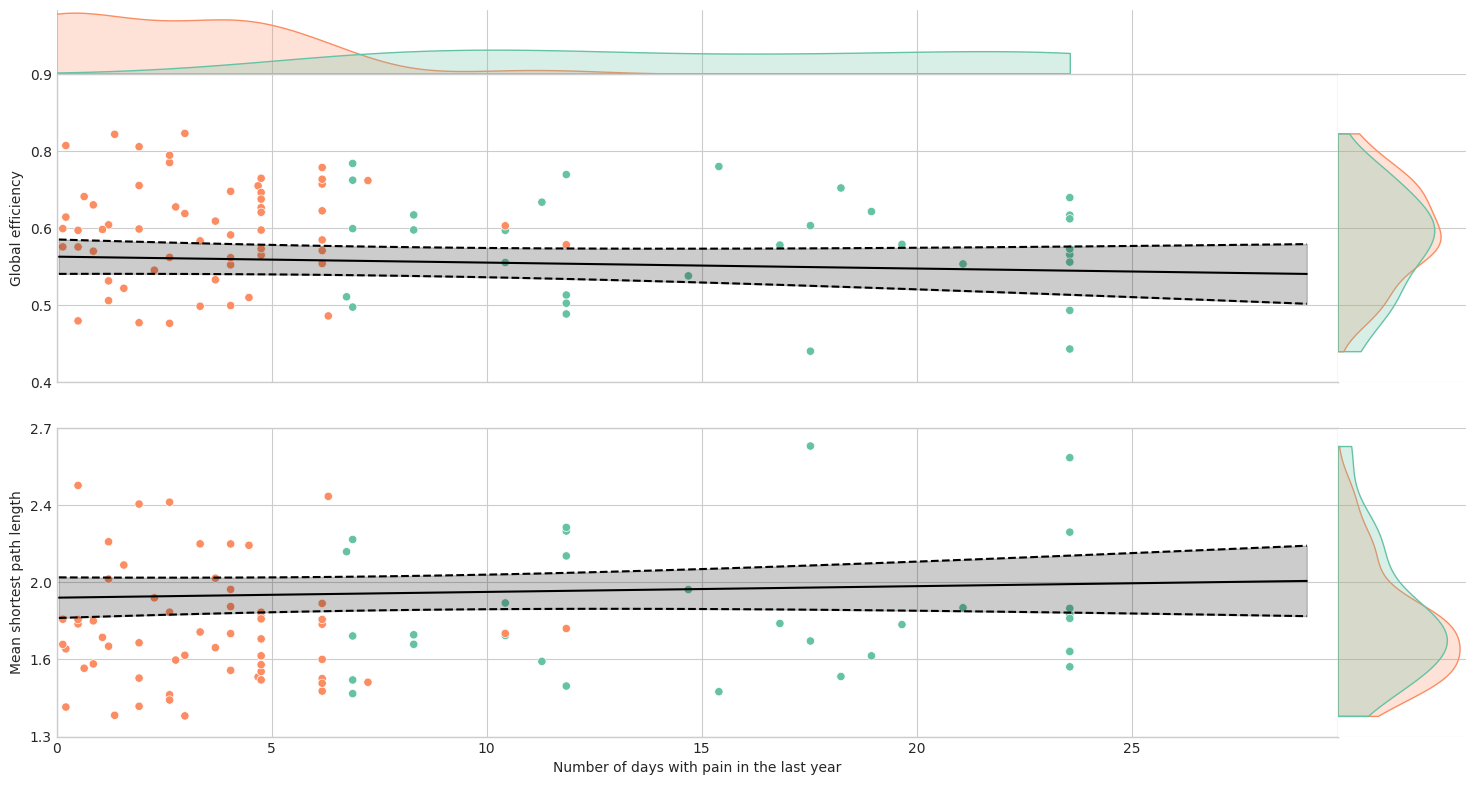

In [53]:
# make a scatterplot with a lmplot for the regressions with 'global_efficiency' as y and 'pain_durtion' as x

# basic figure preparation
fig, axes = plt.subplots(3, 2, figsize=(20, 10), width_ratios=[
                         1, 0.1], height_ratios=[.2, 1, 1], sharex='col', sharey='row')
ax_lm_ge = axes[1, 0]
ax_lm_msp = axes[2, 0]
ax_kde_paindur = axes[0, 0]
ax_kde_ge = axes[1, 1]
ax_kde_msp = axes[2, 1]
axes[0, 1].set_visible(False)

# make a dataframe with the necessary data for the plot (zscored data and Subgroup)
df_PP = analysis_df_PP.select_dtypes(np.number).apply(stats.zscore)
df_PP['Subgroup'] = analysis_df_PP['Subgroup']

# plot the basic plots
# plot the scatterplots
sns.scatterplot(data=df_PP, x='pain_days_last_year', y='global_efficiency',
                hue='Subgroup', palette=cmap, ax=ax_lm_ge, legend=False)
sns.scatterplot(data=df_PP, x='pain_days_last_year', y='mean_shortest_path',
                hue='Subgroup', palette=cmap, ax=ax_lm_msp, legend=False)

# plot the kdeplots and cut them off at min and max values
sns.kdeplot(data=df_PP, x='pain_days_last_year', hue='Subgroup', palette=cmap,
            ax=ax_kde_paindur, legend=False, fill=True, common_norm=False, common_grid=True, cut=0)
sns.kdeplot(data=df_PP, x='global_efficiency', hue='Subgroup', palette=cmap, ax=ax_kde_ge,
            legend=False, fill=True, common_norm=False, common_grid=True, cut=0, vertical=True)
sns.kdeplot(data=df_PP, x='mean_shortest_path', hue='Subgroup', palette=cmap, ax=ax_kde_msp,
            legend=False, fill=True, common_norm=False, common_grid=True, cut=0, vertical=True)

# plot the regression lines
# get the model for the regression
model_ge = model_series['global_efficiency']
model_msp = model_series['mean_shortest_path']

# make a linesapce for the x values and a prediction dataframe
linespace_n = 100
x_pred = np.linspace(df_PP.pain_duration.min(),
                     df_PP.pain_duration.max(), linespace_n)
gender_mean = np.array([np.mean(df_PP.Gender)]*linespace_n)
pred_df = pd.DataFrame({'pain_days_last_year': x_pred, 'Gender': gender_mean})

pred_ge = model_ge.get_prediction(pred_df).summary_frame()
pred_msp = model_msp.get_prediction(pred_df).summary_frame()

# plot the regression lines
ax_lm_ge.plot(x_pred, pred_ge['mean'], color='k')
ax_lm_msp.plot(x_pred, pred_msp['mean'], color='k')

# plot the confidence intervals with shaded areas with the borers beeing dotted lines
ax_lm_ge.fill_between(x_pred, pred_ge['mean_ci_lower'],
                      pred_ge['mean_ci_upper'], color='k', alpha=.2, label='95% CI')
ax_lm_ge.plot(x_pred, pred_ge['mean_ci_lower'], color='k', linestyle='--')
ax_lm_ge.plot(x_pred, pred_ge['mean_ci_upper'], color='k', linestyle='--')

ax_lm_msp.fill_between(x_pred, pred_msp['mean_ci_lower'],
                       pred_msp['mean_ci_upper'], color='k', alpha=.2, label='95% CI')
ax_lm_msp.plot(x_pred, pred_msp['mean_ci_lower'], color='k', linestyle='--')
ax_lm_msp.plot(x_pred, pred_msp['mean_ci_upper'], color='k', linestyle='--')

# adapt the axes
# set the x and y limits to the max and min values of the data +-.1
ax_lm_ge.set_xlim(df_PP.pain_duration.min()-.1, df_PP.pain_duration.max()+.1)

# set the position of the kdeplots
# get the position of the axes
pos_ax_lm_ge = ax_lm_ge.get_position()
pos_ax_lm_msp = ax_lm_msp.get_position()
pos_ax_kde_paindur = ax_kde_paindur.get_position()
pos_ax_kde_ge = ax_kde_ge.get_position()
pos_ax_kde_msp = ax_kde_msp.get_position()
# set the new posaitions
ax_kde_paindur.set_position([pos_ax_lm_ge.x0, pos_ax_lm_ge.y0 +
                             pos_ax_lm_ge.height, pos_ax_lm_ge.width, pos_ax_kde_ge.width])
ax_kde_ge.set_position([pos_ax_lm_ge.x0 + pos_ax_lm_ge.width,
                        pos_ax_lm_ge.y0, pos_ax_kde_ge.width, pos_ax_lm_ge.height])
ax_kde_msp.set_position([pos_ax_lm_msp.x0 + pos_ax_lm_msp.width,
                         pos_ax_lm_msp.y0, pos_ax_kde_msp.width, pos_ax_lm_msp.height])

# remove the borders from the kdeplots
for ax in [ax_kde_ge, ax_kde_msp, ax_kde_paindur]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)


# rebrand the axis to unstandardized ticks and labels
# get the max and ceil them to the next 5
x_max = np.ceil(analysis_df_PP.pain_duration.max()/5)*5
# now make a list for the ticks where every 5th tick is labeled
x_ticks = np.arange(0, x_max+1, 5).astype(int)
# get the equivalent in z scores
x_ticks_z = (x_ticks - analysis_df_PP.pain_duration.mean()) / \
    analysis_df_PP.pain_duration.std()
# set the ticks and labels
ax_lm_ge.set_xticks(x_ticks_z)
ax_lm_ge.set_xticklabels(x_ticks)
# rename the x axis
ax_lm_msp.set_xlabel('Number of days with pain in the last year')

# set x_min to 0
ax_lm_ge.set_xlim((0-analysis_df_PP.pain_duration.mean()) /
                  analysis_df_PP.pain_duration.std(), df_PP.pain_duration.max()+.1)

# get the min and max of the y axis. ceil them to the next .1
y_min_ge = np.floor(analysis_df_PP.global_efficiency.min()*10)/10
y_max_ge = np.ceil(analysis_df_PP.global_efficiency.max()*10)/10
# make a list for the ticks with totally 5 ticks
y_ticks_ge = np.linspace(y_min_ge, y_max_ge, 5)
# get the equivalent in z scores
y_ticks_ge_z = (y_ticks_ge - analysis_df_PP.global_efficiency.mean()
                ) / analysis_df_PP.global_efficiency.std()
# set the ticks and labels
ax_lm_ge.set_yticks(y_ticks_ge_z)
ax_lm_ge.set_yticklabels(np.around(y_ticks_ge, 1))
# rename the y axis
ax_lm_ge.set_ylabel('Global efficiency')

# get the min and max of the y axis. ceil them to the next .1
y_min_msp = np.floor(analysis_df_PP.mean_shortest_path.min()*10)/10
y_max_msp = np.ceil(analysis_df_PP.mean_shortest_path.max()*10)/10
# make a list for the ticks with totally 5 ticks
y_ticks_msp = np.linspace(y_min_msp, y_max_msp, 5)
# get the equivalent in z scores
y_ticks_msp_z = (y_ticks_msp - analysis_df_PP.mean_shortest_path.mean()
                 )/analysis_df_PP.mean_shortest_path.std()
# set the ticks and labels
ax_lm_msp.set_yticks(y_ticks_msp_z)
ax_lm_msp.set_yticklabels(np.around(y_ticks_msp, 1))
# rename the y axis
ax_lm_msp.set_ylabel('Mean shortest path length')


# make kdeplots more beautiful
# for all kde plots remove the density ticks and labels
for ax in [ax_kde_ge, ax_kde_msp]:
    ax.set_xticks([])
    ax.set_xlabel('')

ax_kde_paindur.set_yticks([])
ax_kde_paindur.set_ylabel('')


***Table S6***

In [54]:
# prepare dataframes to store the results
ols_t_results = pd.DataFrame(
    index=graph_features_of_medium_interest, columns=['pain_severity'])
ols_p_results = pd.DataFrame(
    index=graph_features_of_medium_interest, columns=['pain_severity'])
ols_coef_results = pd.DataFrame(
    index=graph_features_of_medium_interest, columns=['pain_severity'])
ols_std_results = pd.DataFrame(
    index=graph_features_of_medium_interest, columns=['pain_severity'])
ols_R2_results = pd.DataFrame(
    index=graph_features_of_medium_interest, columns=[['R2', 'R2_adj', 'p_F']])
model_series = pd.Series(index=graph_features_of_medium_interest)

for graph_feature in graph_features_of_medium_interest:
    # define the model
    model_df = analysis_df_PP.loc[:, [
        graph_feature, 'pain_severity', 'Gender']].copy()
    model_df = model_df.apply(stats.zscore)
    model_df.loc[:, 'Gender'] = analysis_df.loc[:, 'Gender']

    formula = f'{graph_feature} ~  pain_severity + Gender'
    model = smf.ols(formula=formula, data=model_df).fit()

    # add the pain_duration params to the dataframes
    ols_t_results.loc[graph_feature,
                      'pain_severity'] = model.tvalues['pain_severity']
    ols_p_results.loc[graph_feature,
                      'pain_severity'] = model.pvalues['pain_severity']
    ols_coef_results.loc[graph_feature,
                         'pain_severity'] = model.params['pain_severity']
    ols_std_results.loc[graph_feature,
                        'pain_severity'] = model.bse['pain_severity']

    # add the C(Gender) params to the dataframes
    # statsmodels chenges the name of variables, when they are categorical. We need to find the new name
    for idx in model.tvalues.index:
        if 'Gender' in idx:
            gender_var_name = idx
    ols_t_results.loc[graph_feature, 'Gender'] = model.tvalues[gender_var_name]
    ols_p_results.loc[graph_feature, 'Gender'] = model.pvalues[gender_var_name]
    ols_coef_results.loc[graph_feature,
                         'Gender'] = model.params[gender_var_name]
    ols_std_results.loc[graph_feature, 'Gender'] = model.bse[gender_var_name]

    # add the model results to the dataframes
    ols_R2_results.loc[graph_feature, 'R2'] = model.rsquared
    ols_R2_results.loc[graph_feature, 'R2_adj'] = model.rsquared_adj
    ols_R2_results.loc[graph_feature, 'p_F'] = model.f_pvalue

    # add the model to the model_series
    model_series.loc[graph_feature] = model

# convert all to float
ols_t_results = ols_t_results.astype(float)
ols_p_results = ols_p_results.astype(float)
ols_coef_results = ols_coef_results.astype(float)

# do FDR correction
ols_p_results_adj = ols_p_results.apply(
    lambda x: multipletests(x, method='fdr_bh')[1])

# make a nice formatted table
# copy and get only the first three digits
ols_results_summary_table = ols_coef_results.copy().applymap(
    lambda x: f'{x:.3f}').T

# add a star if p<.05 two if p<.01 and three if p<.001
for col in ols_results_summary_table.columns:
    for row in ols_results_summary_table.index:
        if ols_p_results_adj.loc[col, row] < 0.001:
            ols_results_summary_table.loc[row, col] += '***'
        elif ols_p_results_adj.loc[col, row] < 0.01:
            ols_results_summary_table.loc[row, col] += '**'
        elif ols_p_results_adj.loc[col, row] < 0.05:
            ols_results_summary_table.loc[row, col] += '*'
        elif ols_p_results_adj.loc[col, row] < 0.1:
            ols_results_summary_table.loc[row, col] += '°'

# add the std in brackets behind the coef-values
for col in ols_results_summary_table.columns:
    for row in ols_results_summary_table.index:
        ols_results_summary_table.loc[row,
                                      col] += f' ({ols_std_results.loc[col, row]:.3f})'

# add the ols_R2_results.columns to the index of ols_results_summary_table
ols_results_summary_table = ols_results_summary_table.T

# FDR correction for the p_F values
ols_R2_results.loc[:, 'p_F'] = multipletests(
    ols_R2_results.loc[:, 'p_F'].to_numpy().flatten(), method='fdr_bh')[1]

ols_R2_results = ols_R2_results.applymap(lambda x: f'{x:.3f}')
pd.concat([ols_results_summary_table, ols_R2_results], axis=1).T


/tmp/ipykernel_2434536/1556218344.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  model_series = pd.Series(index=graph_features_of_medium_interest)


,global_efficiency,mean_shortest_path,small_world,node_degree_WB,closeness_centrality
pain_severity,-0.051 (0.089),0.044 (0.089),0.064 (0.094),-0.140 (0.092),-0.120 (0.091)
Gender,0.854*** (0.185),-0.845*** (0.186),-0.556** (0.196),0.657** (0.191),0.741*** (0.189)
"(R2,)",0.169,0.165,0.074,0.115,0.137
"(R2_adj,)",0.153,0.149,0.056,0.098,0.121
"(p_F,)",0.000,0.000,0.018,0.002,0.001


***Figure S1B***

/gxfs_home/cau/suknp018/miniconda3/envs/B03_virtenv/lib/python3.11/site-packages/seaborn/distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/gxfs_home/cau/suknp018/miniconda3/envs/B03_virtenv/lib/python3.11/site-packages/seaborn/distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '')

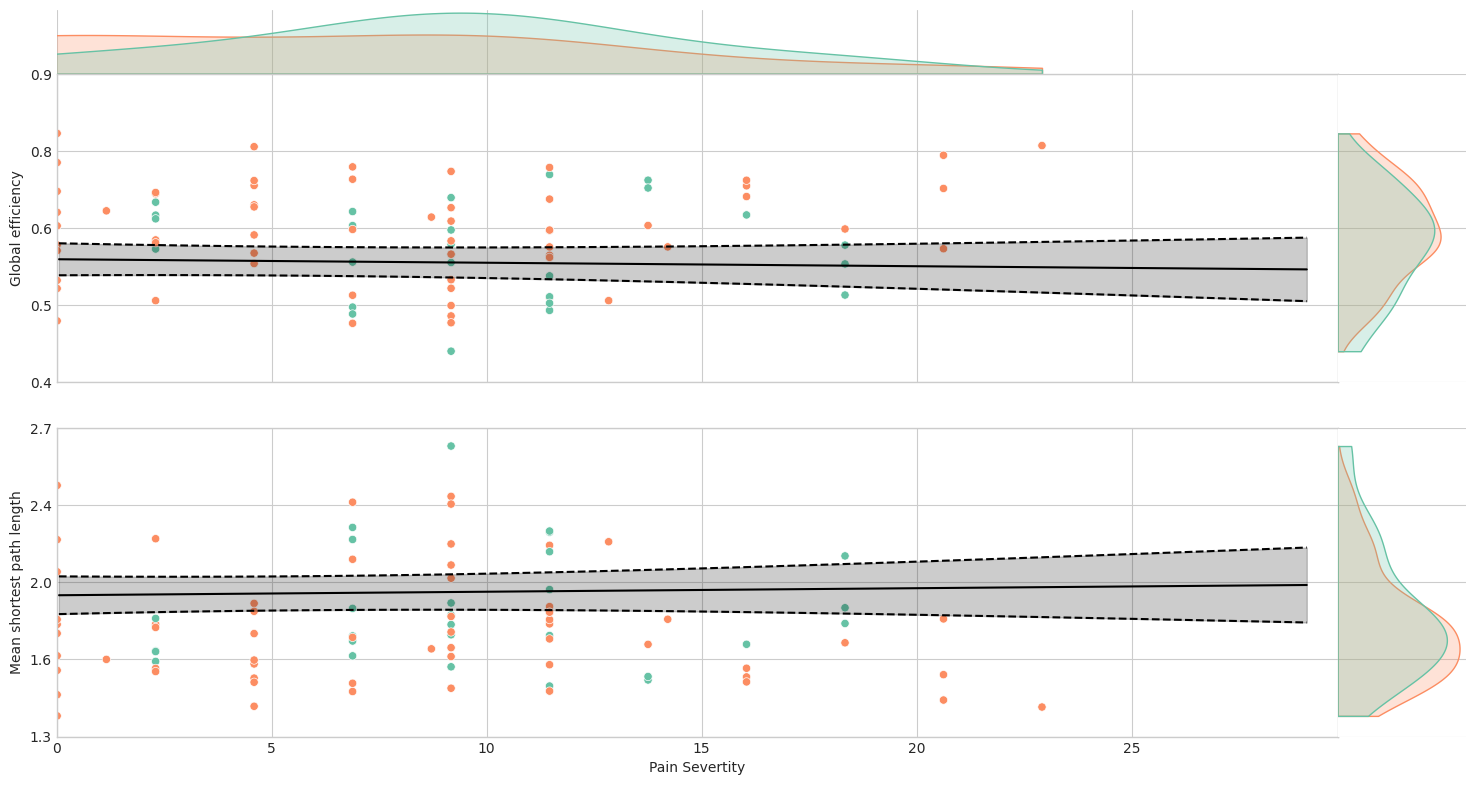

In [55]:
# make a scatterplot with a lmplot for the regressions with 'global_efficiency' as y and 'pain_durtion' as x

# basic figure preparation
fig, axes = plt.subplots(3, 2, figsize=(20, 10), width_ratios=[
                         1, 0.1], height_ratios=[.2, 1, 1], sharex='col', sharey='row')
ax_lm_ge = axes[1, 0]
ax_lm_msp = axes[2, 0]
ax_kde_paindur = axes[0, 0]
ax_kde_ge = axes[1, 1]
ax_kde_msp = axes[2, 1]
axes[0, 1].set_visible(False)

# make a dataframe with the necessary data for the plot (zscored data and Subgroup)
df_PP = analysis_df_PP.select_dtypes(np.number).apply(stats.zscore)
df_PP['Subgroup'] = analysis_df_PP['Subgroup']

# plot the basic plots
# plot the scatterplots
sns.scatterplot(data=df_PP, x='pain_severity', y='global_efficiency',
                hue='Subgroup', palette=cmap, ax=ax_lm_ge, legend=False)
sns.scatterplot(data=df_PP, x='pain_severity', y='mean_shortest_path',
                hue='Subgroup', palette=cmap, ax=ax_lm_msp, legend=False)

# plot the kdeplots and cut them off at min and max values
sns.kdeplot(data=df_PP, x='pain_severity', hue='Subgroup', palette=cmap,
            ax=ax_kde_paindur, legend=False, fill=True, common_norm=False, common_grid=True, cut=0)
sns.kdeplot(data=df_PP, x='global_efficiency', hue='Subgroup', palette=cmap, ax=ax_kde_ge,
            legend=False, fill=True, common_norm=False, common_grid=True, cut=0, vertical=True)
sns.kdeplot(data=df_PP, x='mean_shortest_path', hue='Subgroup', palette=cmap, ax=ax_kde_msp,
            legend=False, fill=True, common_norm=False, common_grid=True, cut=0, vertical=True)

# plot the regression lines
# get the model for the regression
model_ge = model_series['global_efficiency']
model_msp = model_series['mean_shortest_path']

# make a linesapce for the x values and a prediction dataframe
linespace_n = 100
x_pred = np.linspace(df_PP.pain_duration.min(),
                     df_PP.pain_duration.max(), linespace_n)
gender_mean = np.array([np.mean(df_PP.Gender)]*linespace_n)
pred_df = pd.DataFrame({'pain_severity': x_pred, 'Gender': gender_mean})

pred_ge = model_ge.get_prediction(pred_df).summary_frame()
pred_msp = model_msp.get_prediction(pred_df).summary_frame()

# plot the regression lines
ax_lm_ge.plot(x_pred, pred_ge['mean'], color='k')
ax_lm_msp.plot(x_pred, pred_msp['mean'], color='k')

# plot the confidence intervals with shaded areas with the borers beeing dotted lines
ax_lm_ge.fill_between(x_pred, pred_ge['mean_ci_lower'],
                      pred_ge['mean_ci_upper'], color='k', alpha=.2, label='95% CI')
ax_lm_ge.plot(x_pred, pred_ge['mean_ci_lower'], color='k', linestyle='--')
ax_lm_ge.plot(x_pred, pred_ge['mean_ci_upper'], color='k', linestyle='--')

ax_lm_msp.fill_between(x_pred, pred_msp['mean_ci_lower'],
                       pred_msp['mean_ci_upper'], color='k', alpha=.2, label='95% CI')
ax_lm_msp.plot(x_pred, pred_msp['mean_ci_lower'], color='k', linestyle='--')
ax_lm_msp.plot(x_pred, pred_msp['mean_ci_upper'], color='k', linestyle='--')

# adapt the axes
# set the x and y limits to the max and min values of the data +-.1
ax_lm_ge.set_xlim(df_PP.pain_duration.min()-.1, df_PP.pain_duration.max()+.1)

# set the position of the kdeplots
# get the position of the axes
pos_ax_lm_ge = ax_lm_ge.get_position()
pos_ax_lm_msp = ax_lm_msp.get_position()
pos_ax_kde_paindur = ax_kde_paindur.get_position()
pos_ax_kde_ge = ax_kde_ge.get_position()
pos_ax_kde_msp = ax_kde_msp.get_position()
# set the new posaitions
ax_kde_paindur.set_position([pos_ax_lm_ge.x0, pos_ax_lm_ge.y0 +
                             pos_ax_lm_ge.height, pos_ax_lm_ge.width, pos_ax_kde_ge.width])
ax_kde_ge.set_position([pos_ax_lm_ge.x0 + pos_ax_lm_ge.width,
                        pos_ax_lm_ge.y0, pos_ax_kde_ge.width, pos_ax_lm_ge.height])
ax_kde_msp.set_position([pos_ax_lm_msp.x0 + pos_ax_lm_msp.width,
                         pos_ax_lm_msp.y0, pos_ax_kde_msp.width, pos_ax_lm_msp.height])

# remove the borders from the kdeplots
for ax in [ax_kde_ge, ax_kde_msp, ax_kde_paindur]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)


# rebrand the axis to unstandardized ticks and labels
# get the max and ceil them to the next 5
x_max = np.ceil(analysis_df_PP.pain_duration.max()/5)*5
# now make a list for the ticks where every 5th tick is labeled
x_ticks = np.arange(0, x_max+1, 5).astype(int)
# get the equivalent in z scores
x_ticks_z = (x_ticks - analysis_df_PP.pain_duration.mean()) / \
    analysis_df_PP.pain_duration.std()
# set the ticks and labels
ax_lm_ge.set_xticks(x_ticks_z)
ax_lm_ge.set_xticklabels(x_ticks)
# rename the x axis
ax_lm_msp.set_xlabel('Pain Severtity')

# set x_min to 0
ax_lm_ge.set_xlim((0-analysis_df_PP.pain_duration.mean()) /
                  analysis_df_PP.pain_duration.std(), df_PP.pain_duration.max()+.1)

# get the min and max of the y axis. ceil them to the next .1
y_min_ge = np.floor(analysis_df_PP.global_efficiency.min()*10)/10
y_max_ge = np.ceil(analysis_df_PP.global_efficiency.max()*10)/10
# make a list for the ticks with totally 5 ticks
y_ticks_ge = np.linspace(y_min_ge, y_max_ge, 5)
# get the equivalent in z scores
y_ticks_ge_z = (y_ticks_ge - analysis_df_PP.global_efficiency.mean()
                ) / analysis_df_PP.global_efficiency.std()
# set the ticks and labels
ax_lm_ge.set_yticks(y_ticks_ge_z)
ax_lm_ge.set_yticklabels(np.around(y_ticks_ge, 1))
# rename the y axis
ax_lm_ge.set_ylabel('Global efficiency')

# get the min and max of the y axis. ceil them to the next .1
y_min_msp = np.floor(analysis_df_PP.mean_shortest_path.min()*10)/10
y_max_msp = np.ceil(analysis_df_PP.mean_shortest_path.max()*10)/10
# make a list for the ticks with totally 5 ticks
y_ticks_msp = np.linspace(y_min_msp, y_max_msp, 5)
# get the equivalent in z scores
y_ticks_msp_z = (y_ticks_msp - analysis_df_PP.mean_shortest_path.mean()
                 )/analysis_df_PP.mean_shortest_path.std()
# set the ticks and labels
ax_lm_msp.set_yticks(y_ticks_msp_z)
ax_lm_msp.set_yticklabels(np.around(y_ticks_msp, 1))
# rename the y axis
ax_lm_msp.set_ylabel('Mean shortest path length')


# make kdeplots more beautiful
# for all kde plots remove the density ticks and labels
for ax in [ax_kde_ge, ax_kde_msp]:
    ax.set_xticks([])
    ax.set_xlabel('')

ax_kde_paindur.set_yticks([])
ax_kde_paindur.set_ylabel('')


Packages and Versions  

In [56]:
# Show which version of python is used and which packages are installed and with which version
import sys
print('Python: ' + sys.version + '\n' + 'Packages: ')
for package in sys.modules:
    try:
        print(package + ': ' + sys.modules[package].__version__)
    except:
        continue


Python: 3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 08:57:19) [GCC 11.3.0]
Packages: 
re: 2.2.1
ipykernel._version: 6.19.2
json: 2.0.9
jupyter_client._version: 8.1.0
platform: 1.0.8
_ctypes: 1.1.0
ctypes: 1.1.0
zmq.sugar.version: 23.2.0
zmq.sugar: 23.2.0
zmq: 23.2.0
logging: 0.5.1.2
traitlets._version: 5.7.1
traitlets: 5.7.1
jupyter_core.version: 5.3.0
jupyter_core: 5.3.0
zlib: 1.0
socketserver: 0.4
argparse: 1.1
dateutil: 2.8.2
six: 1.16.0
_decimal: 1.70
decimal: 1.70
platformdirs.version: 3.2.0
platformdirs: 3.2.0
_csv: 1.0
csv: 1.0
jupyter_client: 8.1.0
ipykernel: 6.19.2
IPython.core.release: 8.12.0
executing.version: 0.8.3
executing: 0.8.3
pure_eval.version: 0.2.2
pure_eval: 0.2.2
stack_data.version: 0.2.0
stack_data: 0.2.0
pygments: 2.11.2
ptyprocess: 0.7.0
pexpect: 4.8.0
pickleshare: 0.7.5
backcall: 0.2.0
decorator: 5.1.1
wcwidth: 0.2.5
prompt_toolkit: 3.0.36
parso: 0.8.3
jedi: 0.18.1
urllib.request: 3.11
IPython: 8.12.0
comm: 0.1.2
psutil: 5.9.4
debugpy: 1.5.1
xmlrpc.